# <center>Time series analysis in Python</center>

Original source: https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb#Time-series-lags

# Practical session outline:

1. [Linear (and not quite) models for time series](#Linear-(and-not-quite)-models-for-time-series)
   - [Feature extraction](#Feature-extraction)
   - [Time series lags](#Time-series-lags)
   - [Target encoding](#Target-encoding)
   - [Regularization and feature selection](#Regularization-and-feature-selection)
   - [Boosting](#Boosting)
2. [Conclusion](#Conclusion)
3. [Demo assignment](#Demo-assignment)
4. [Useful resources](#Useful-resources)

In [2]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

As an example, let's look at real mobile game data. Specifically, we will look into ads watched per hour and in-game currency spend per day.
The dataset size is well adapted to our practical session.

In [3]:
ads = pd.read_csv('https://raw.githubusercontent.com/vguigue/TimeSeries/main/data/ads.csv', index_col=['Time'],
                  parse_dates=['Time'])
currency = pd.read_csv('https://raw.githubusercontent.com/vguigue/TimeSeries/main/data/currency.csv', index_col=['Time'],
                       parse_dates=['Time'])

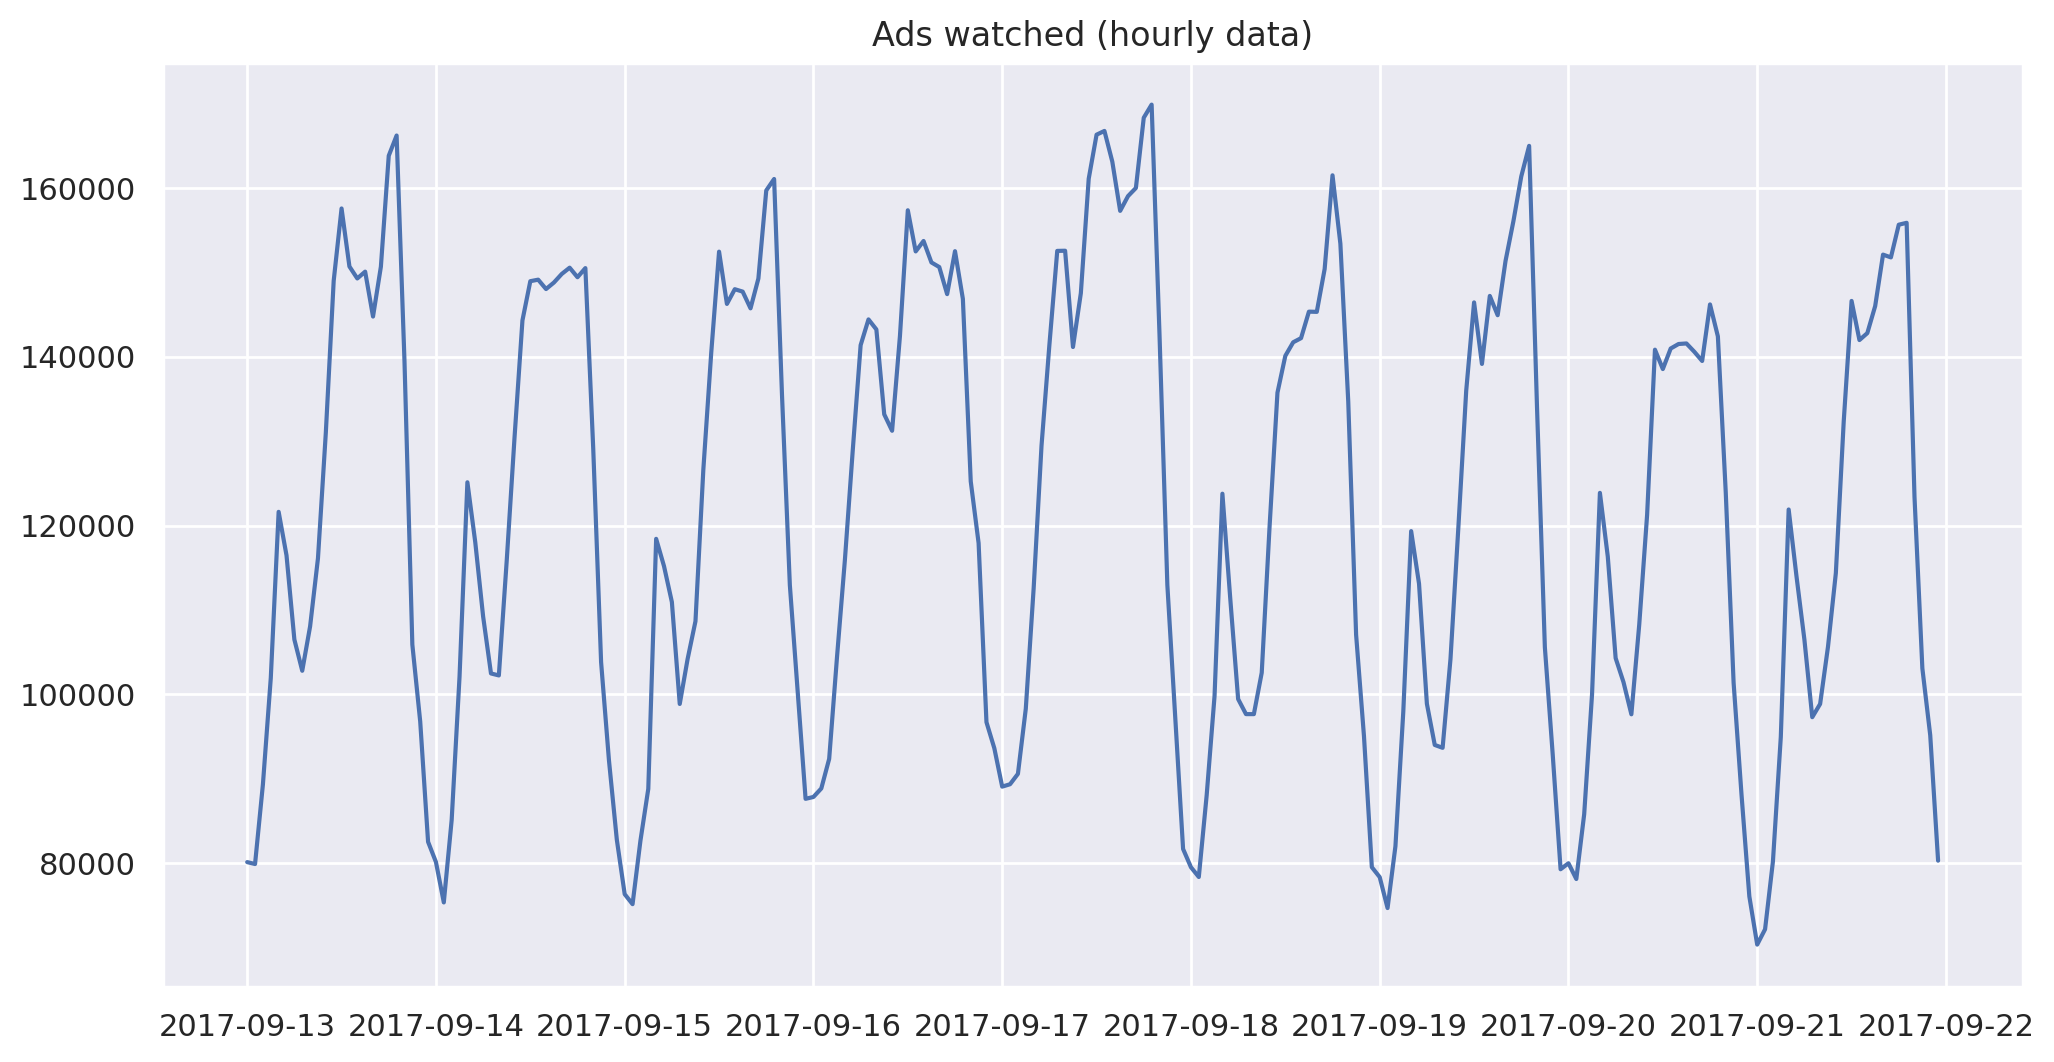

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$

```python
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [11]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit,KFold,ShuffleSplit

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
# Test

print(mean_absolute_percentage_error(np.array([12,8,7]),np.array([15,3,12])))  ## 52.976190476190474
print(mean_absolute_percentage_error(np.array([11,8,5]),np.array([15,3,12])))  ## 79.62121212121212
print(mean_absolute_percentage_error(np.array([4,4,4]),np.array([15,3,12])))   ## 166.66666666666669

52.976190476190474
79.62121212121212
166.66666666666669


Now that we know how to measure the quality of the forecasts, let's see what metrics we can use and how to translate the results for the boss. After that, one small detail remains - building the model.

## Time series lags

Shifting the series $n$ steps back, we get a feature column where the current value of time series is aligned with its value at time $t-n$. If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [7]:
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


## Creating a training/testing set:

In [8]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test


y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

## Our 1st model !

In [9]:
from sklearn.linear_model import LinearRegression


# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    """

    prediction = model.predict(X_test) # compute prediction

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals: # interval from output variances
        cv = cross_val_score(model, X_train, y_train,
                                    cv=TimeSeriesSplit(n_splits=5),
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        print("Cross-Validation MAE:", mae)

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    mae_error = mean_absolute_error(prediction,y_test)

    print("Test MAE:", mae_error)

    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);



In [15]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
        attribute coef_
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');


Cross-Validation MAE: 12237.615807309034
Test MAE: 6791.4506966226645


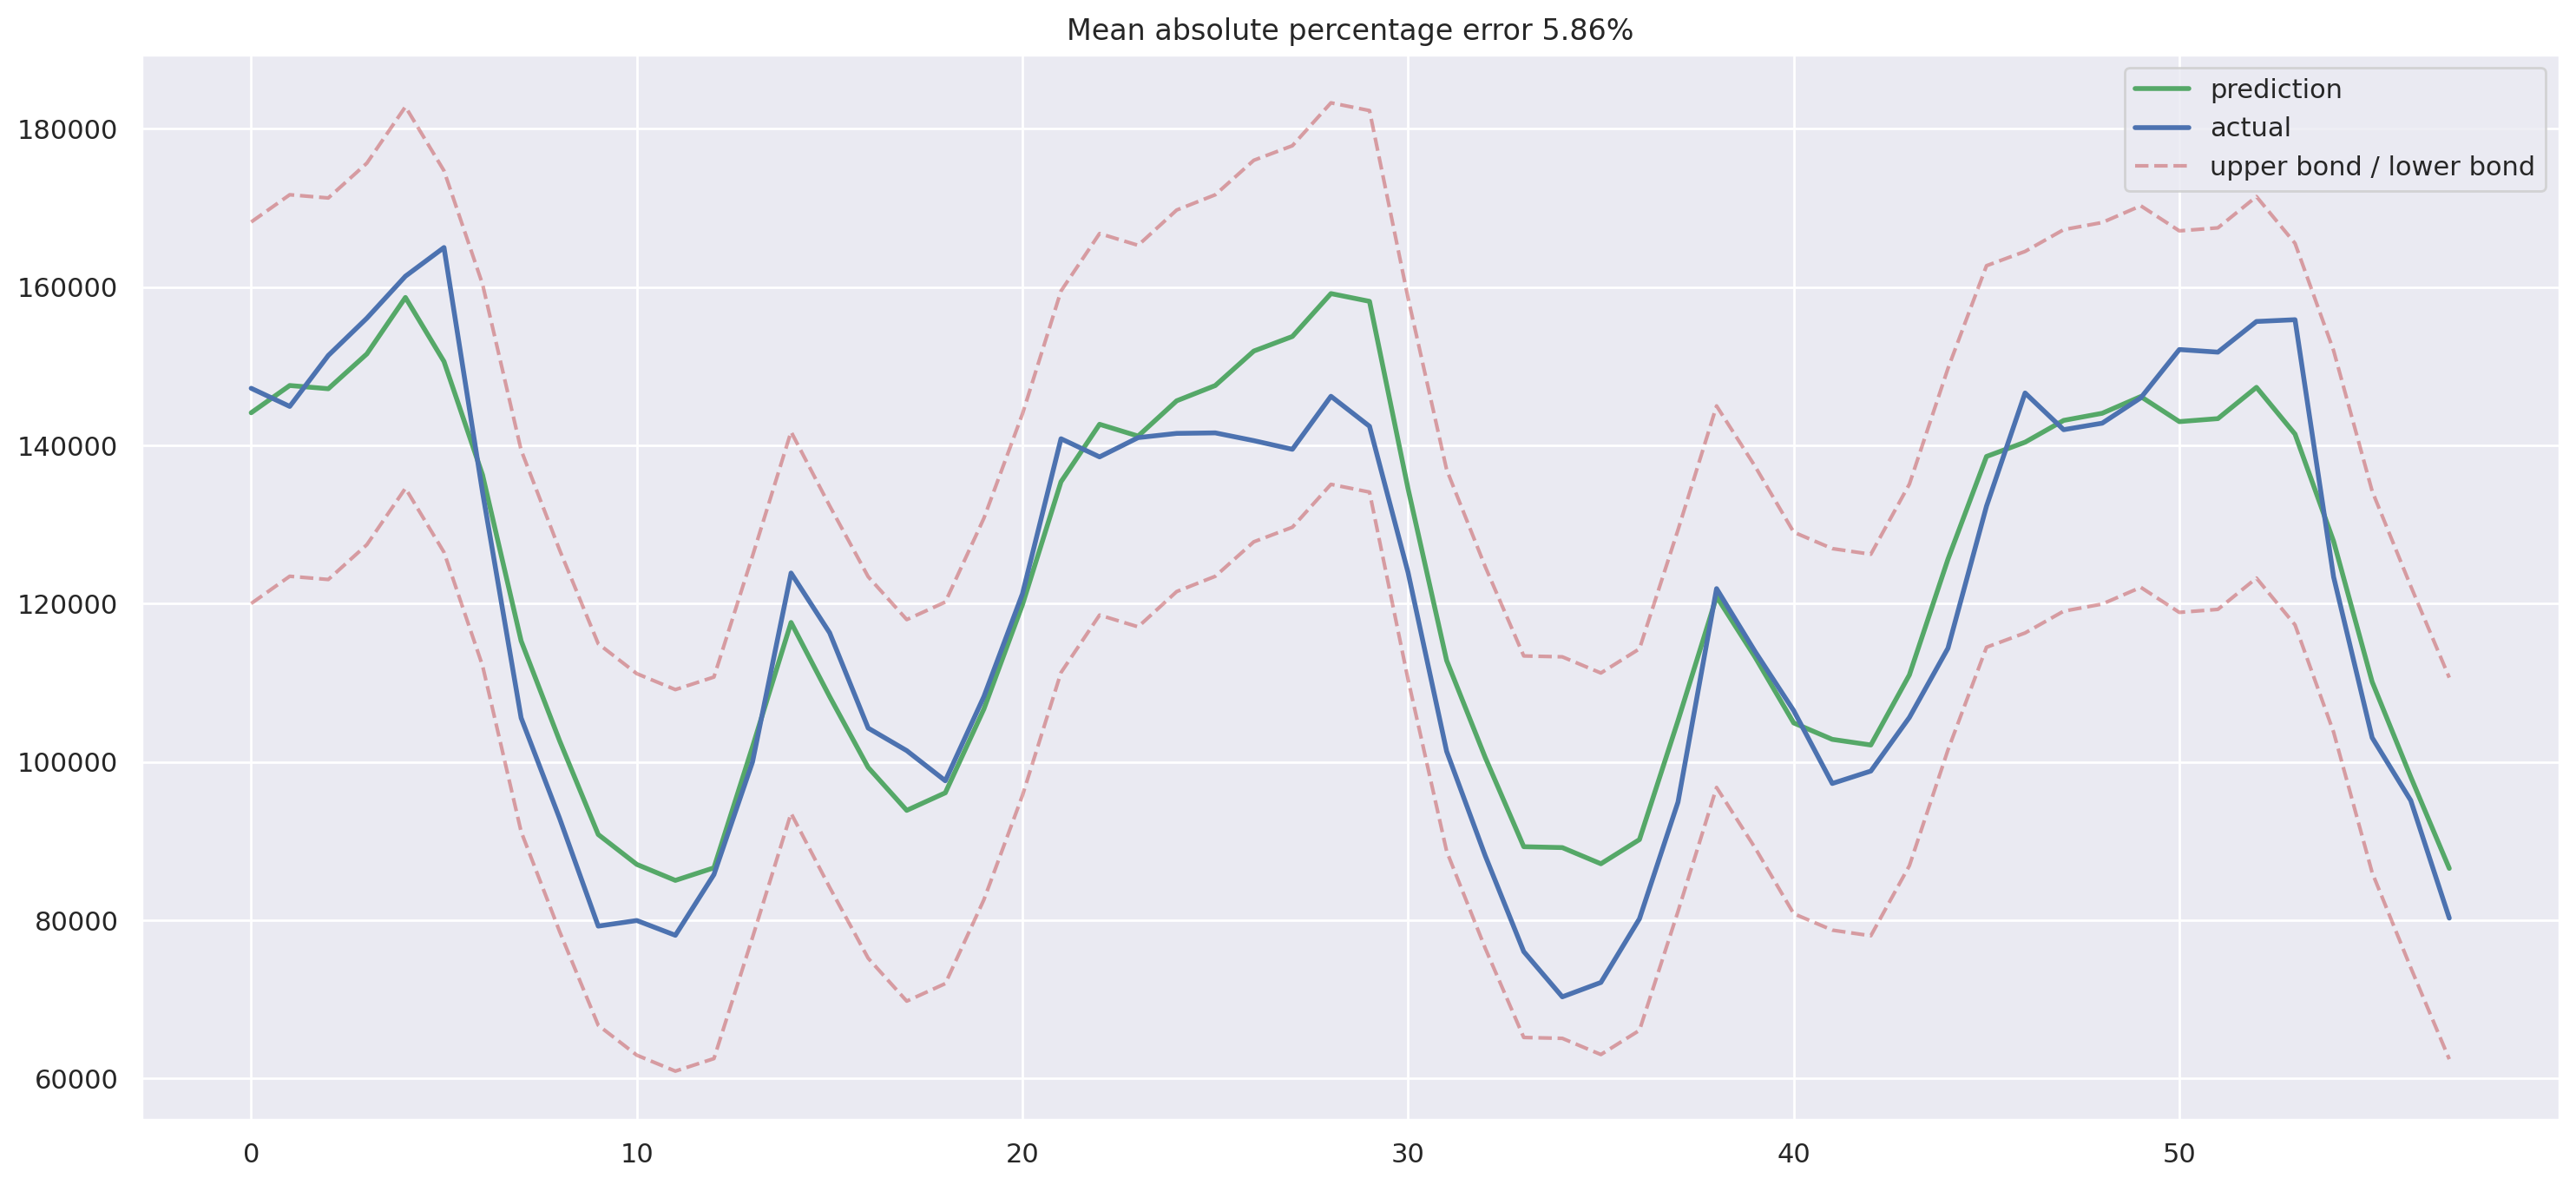

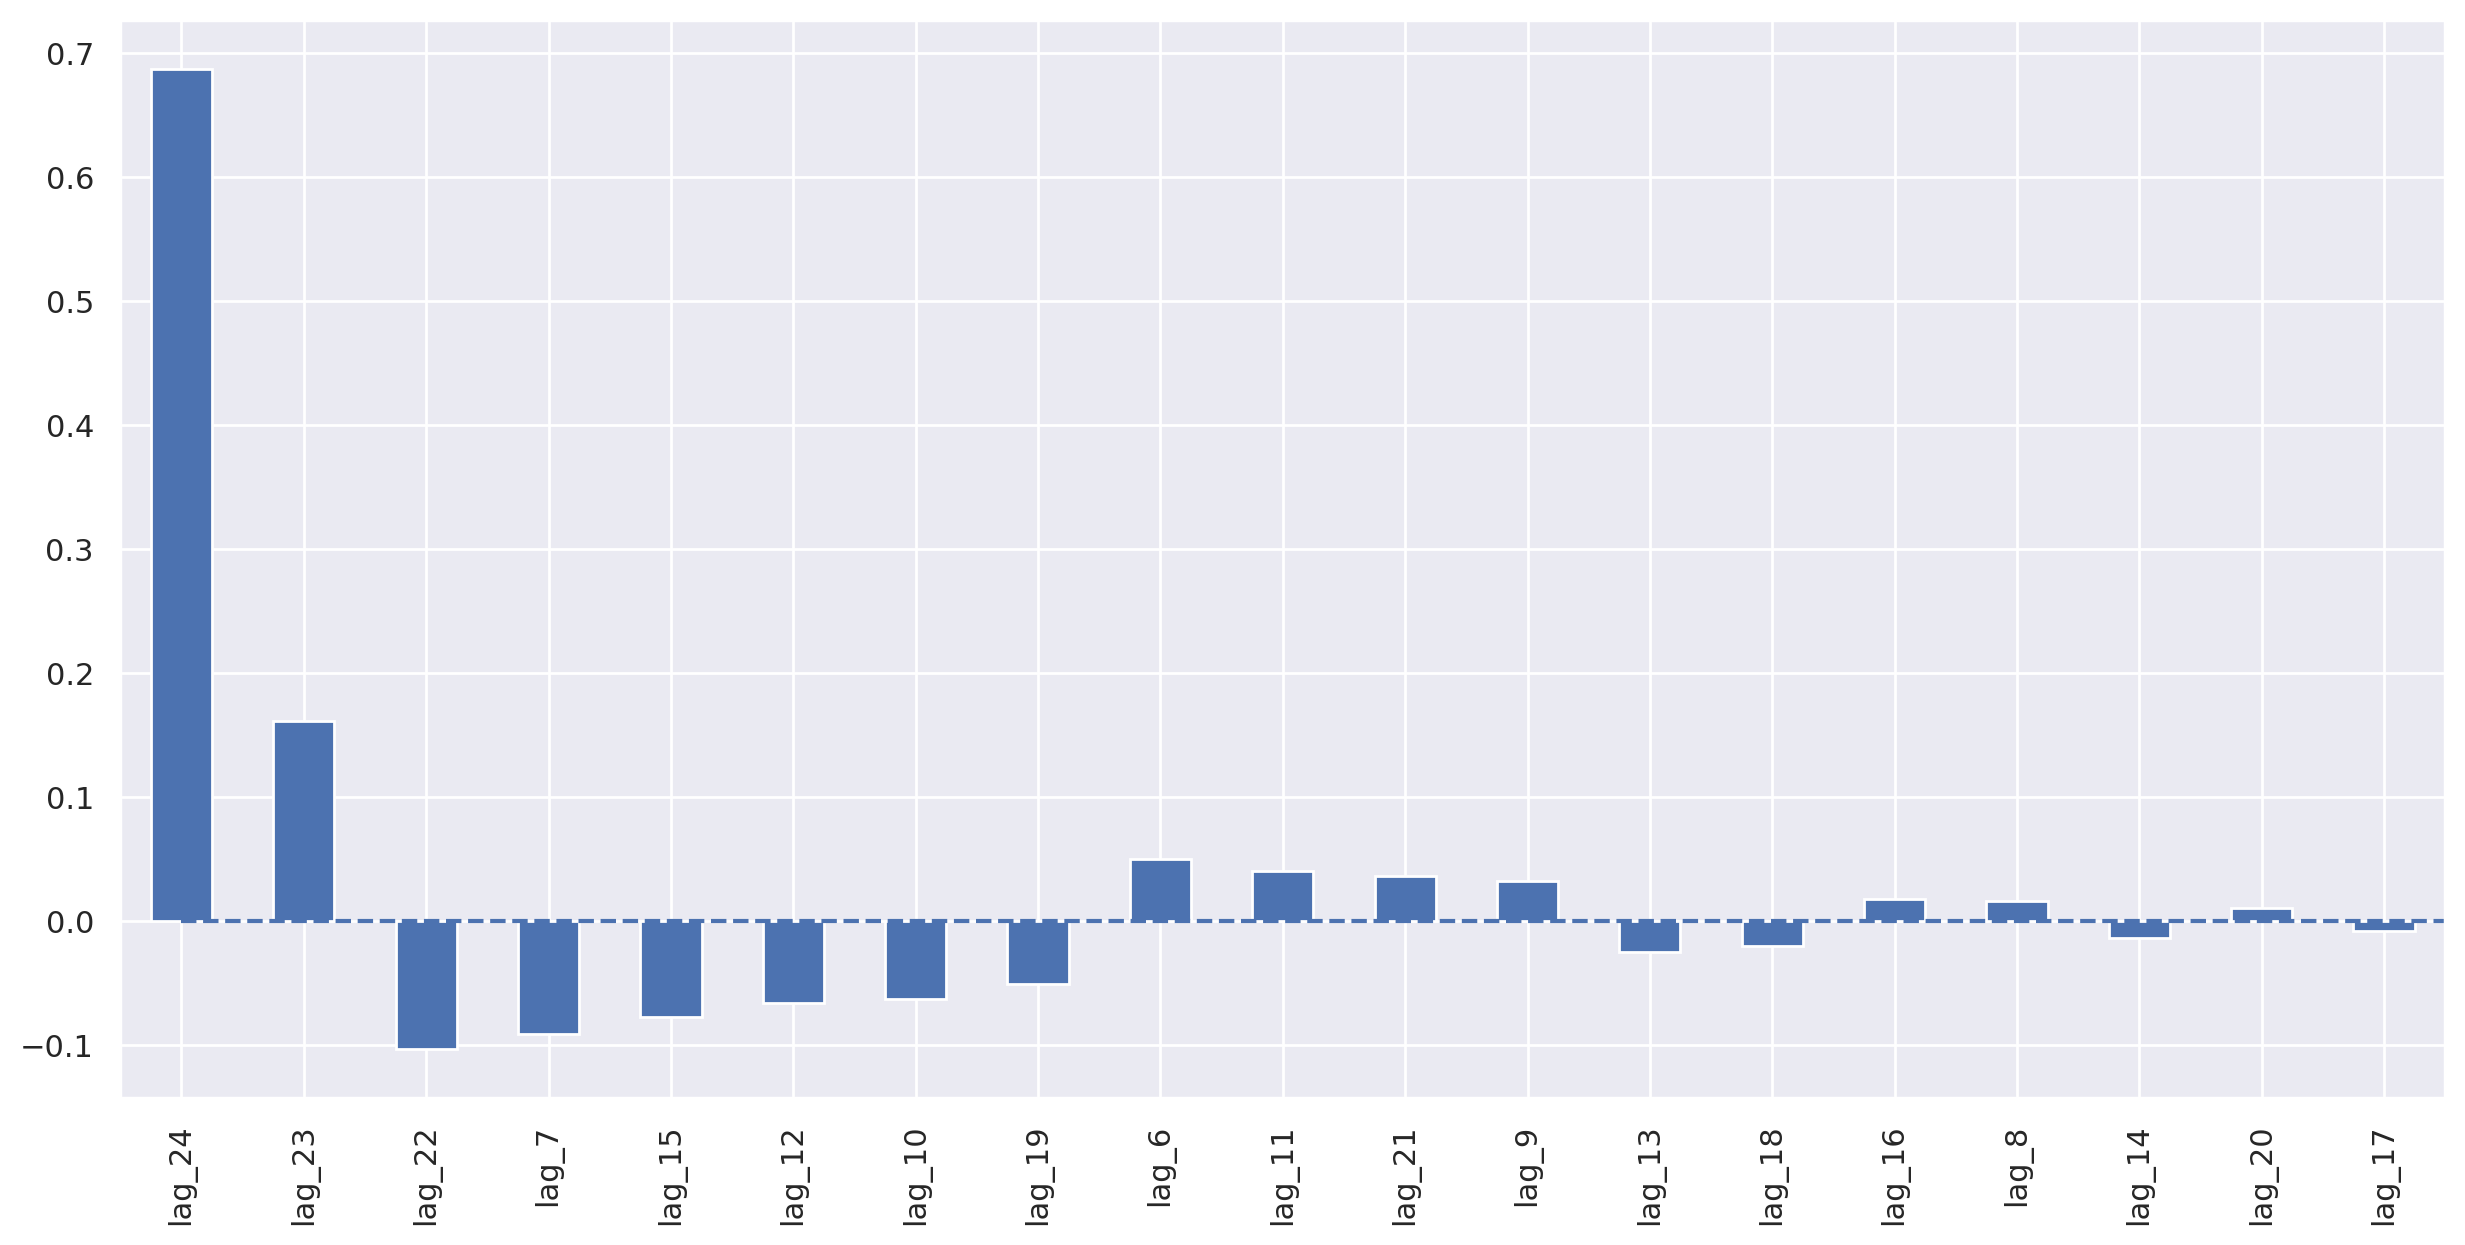

In [16]:

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us predictions that are not that far off from SARIMA in terms of quality. There are many unnecessary features, so we'll do feature selection in a little while. For now, let's continue engineering!

In [17]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


We can visualize the resulting features.

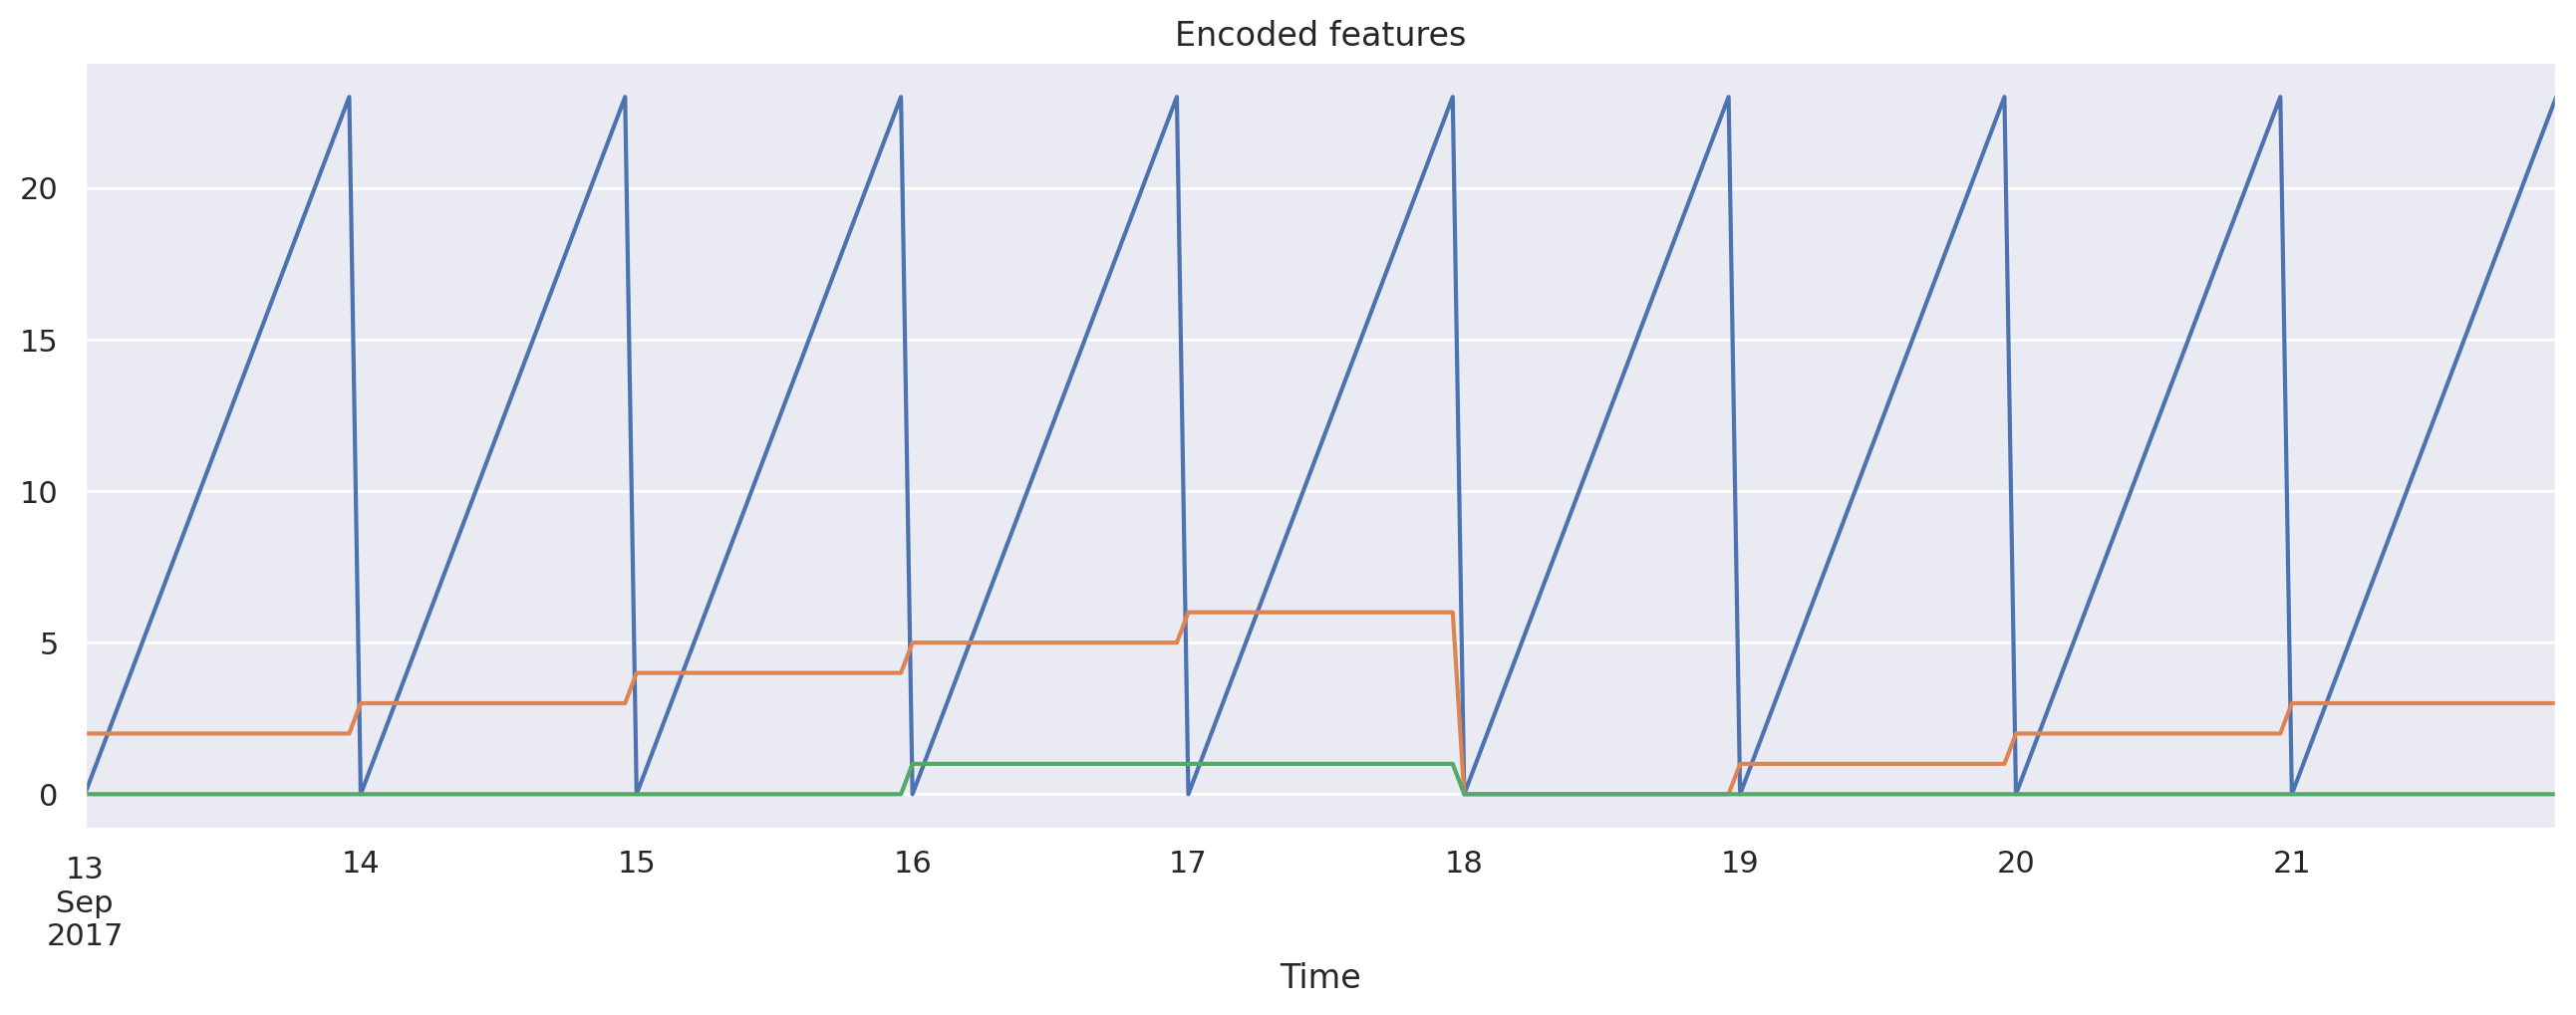

In [18]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization.

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Cross-Validation MAE: 10077.660274550477
Test MAE: 6377.11125023521


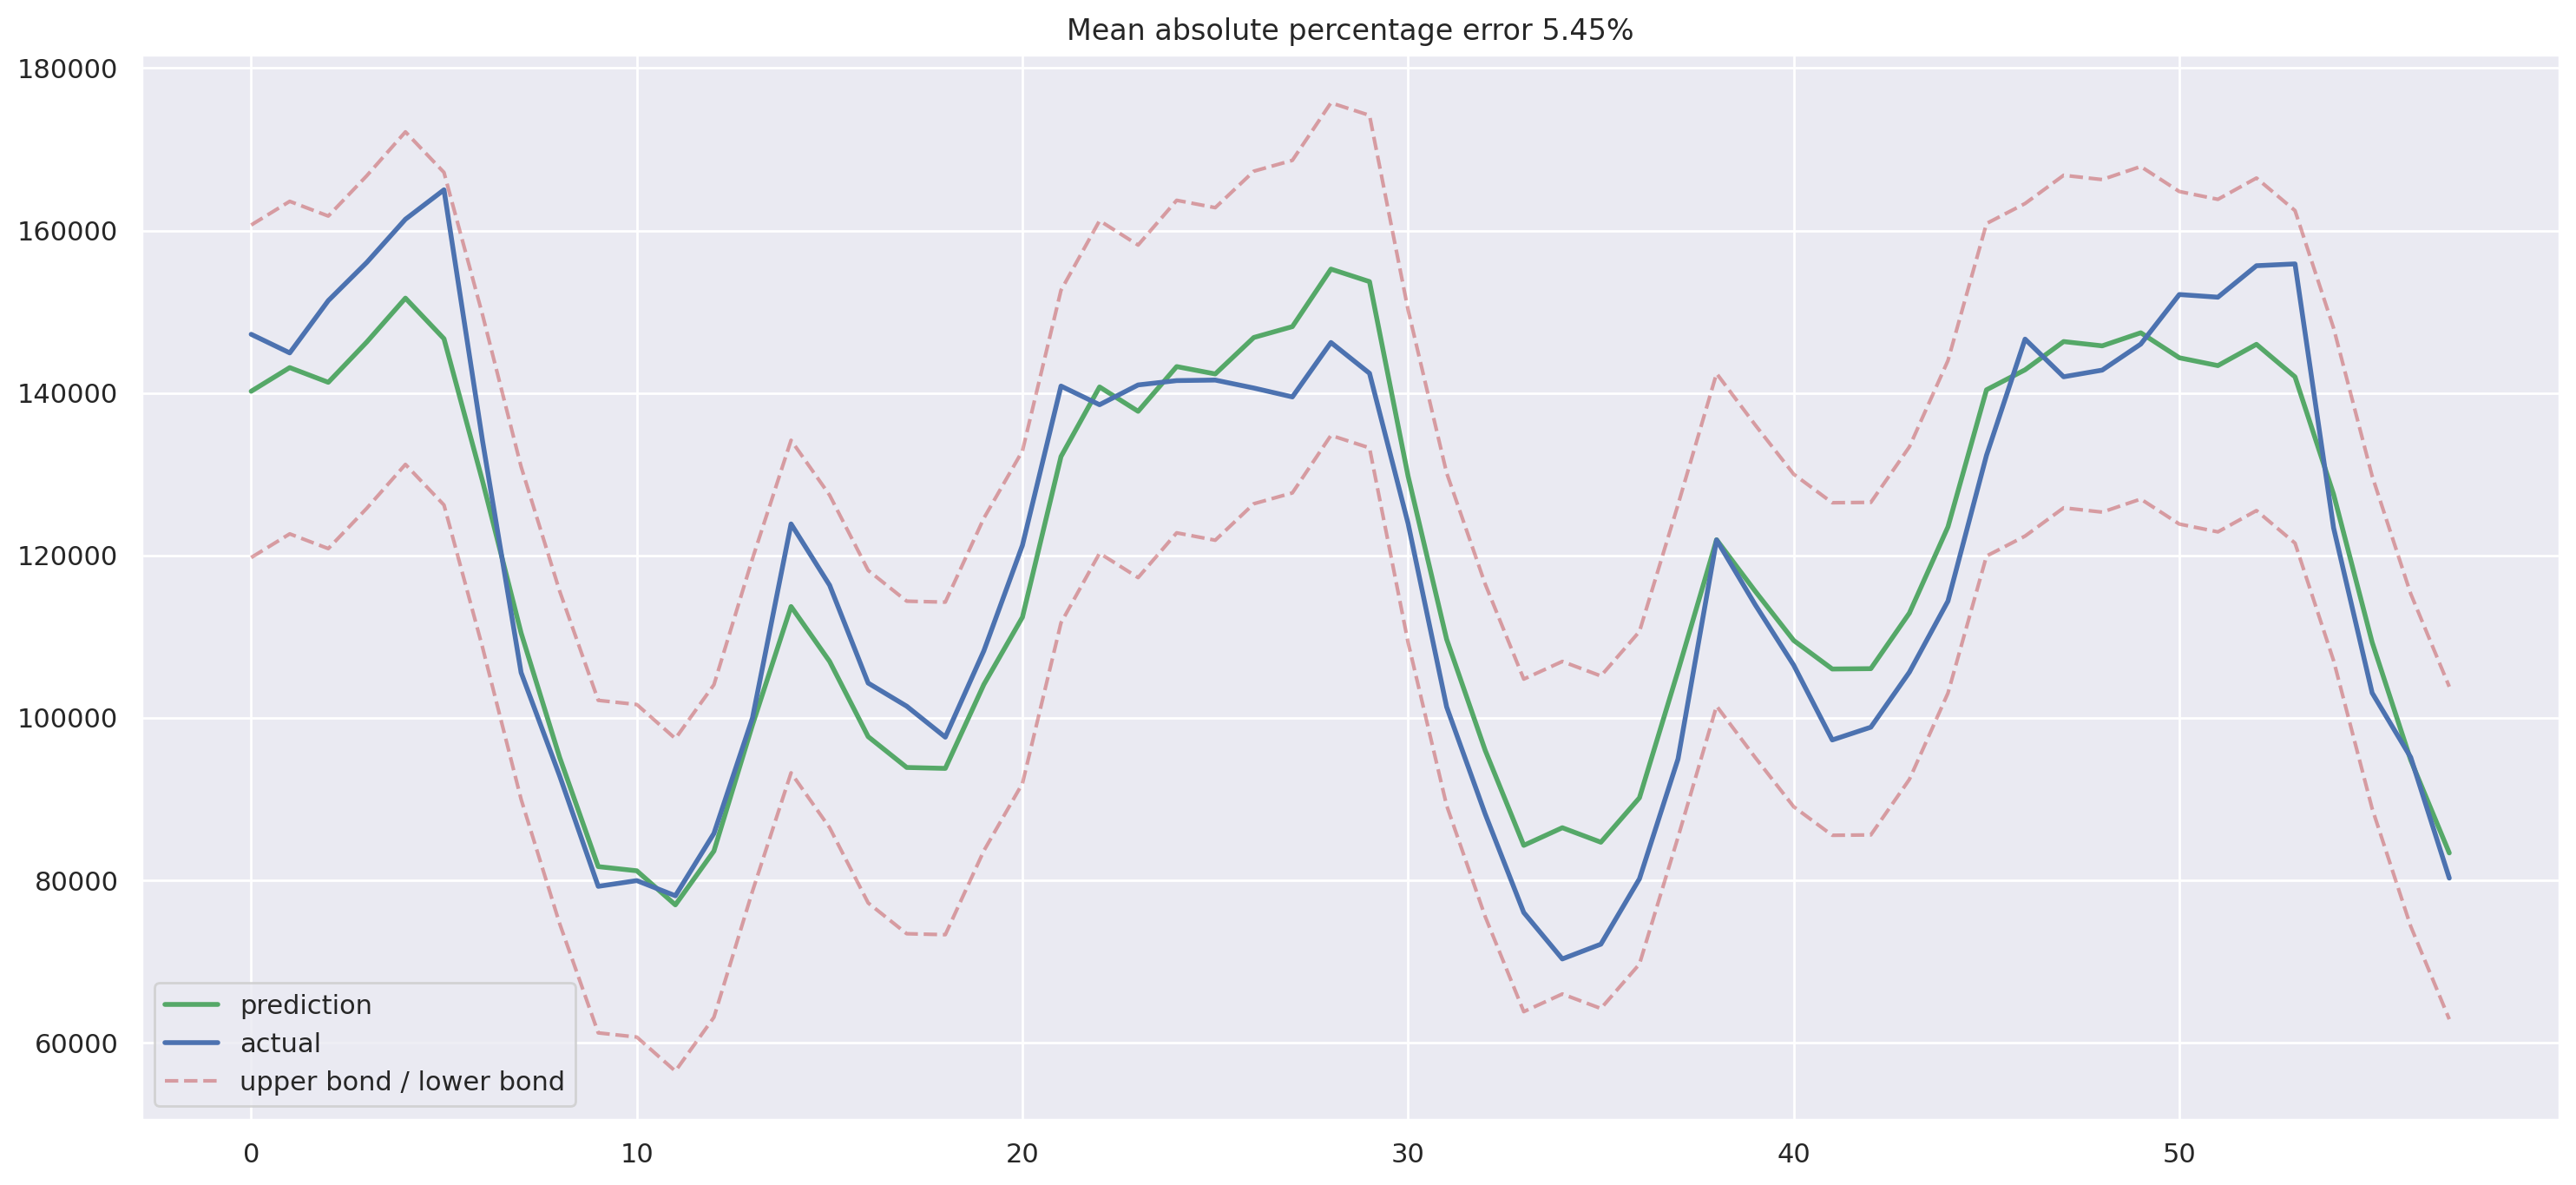

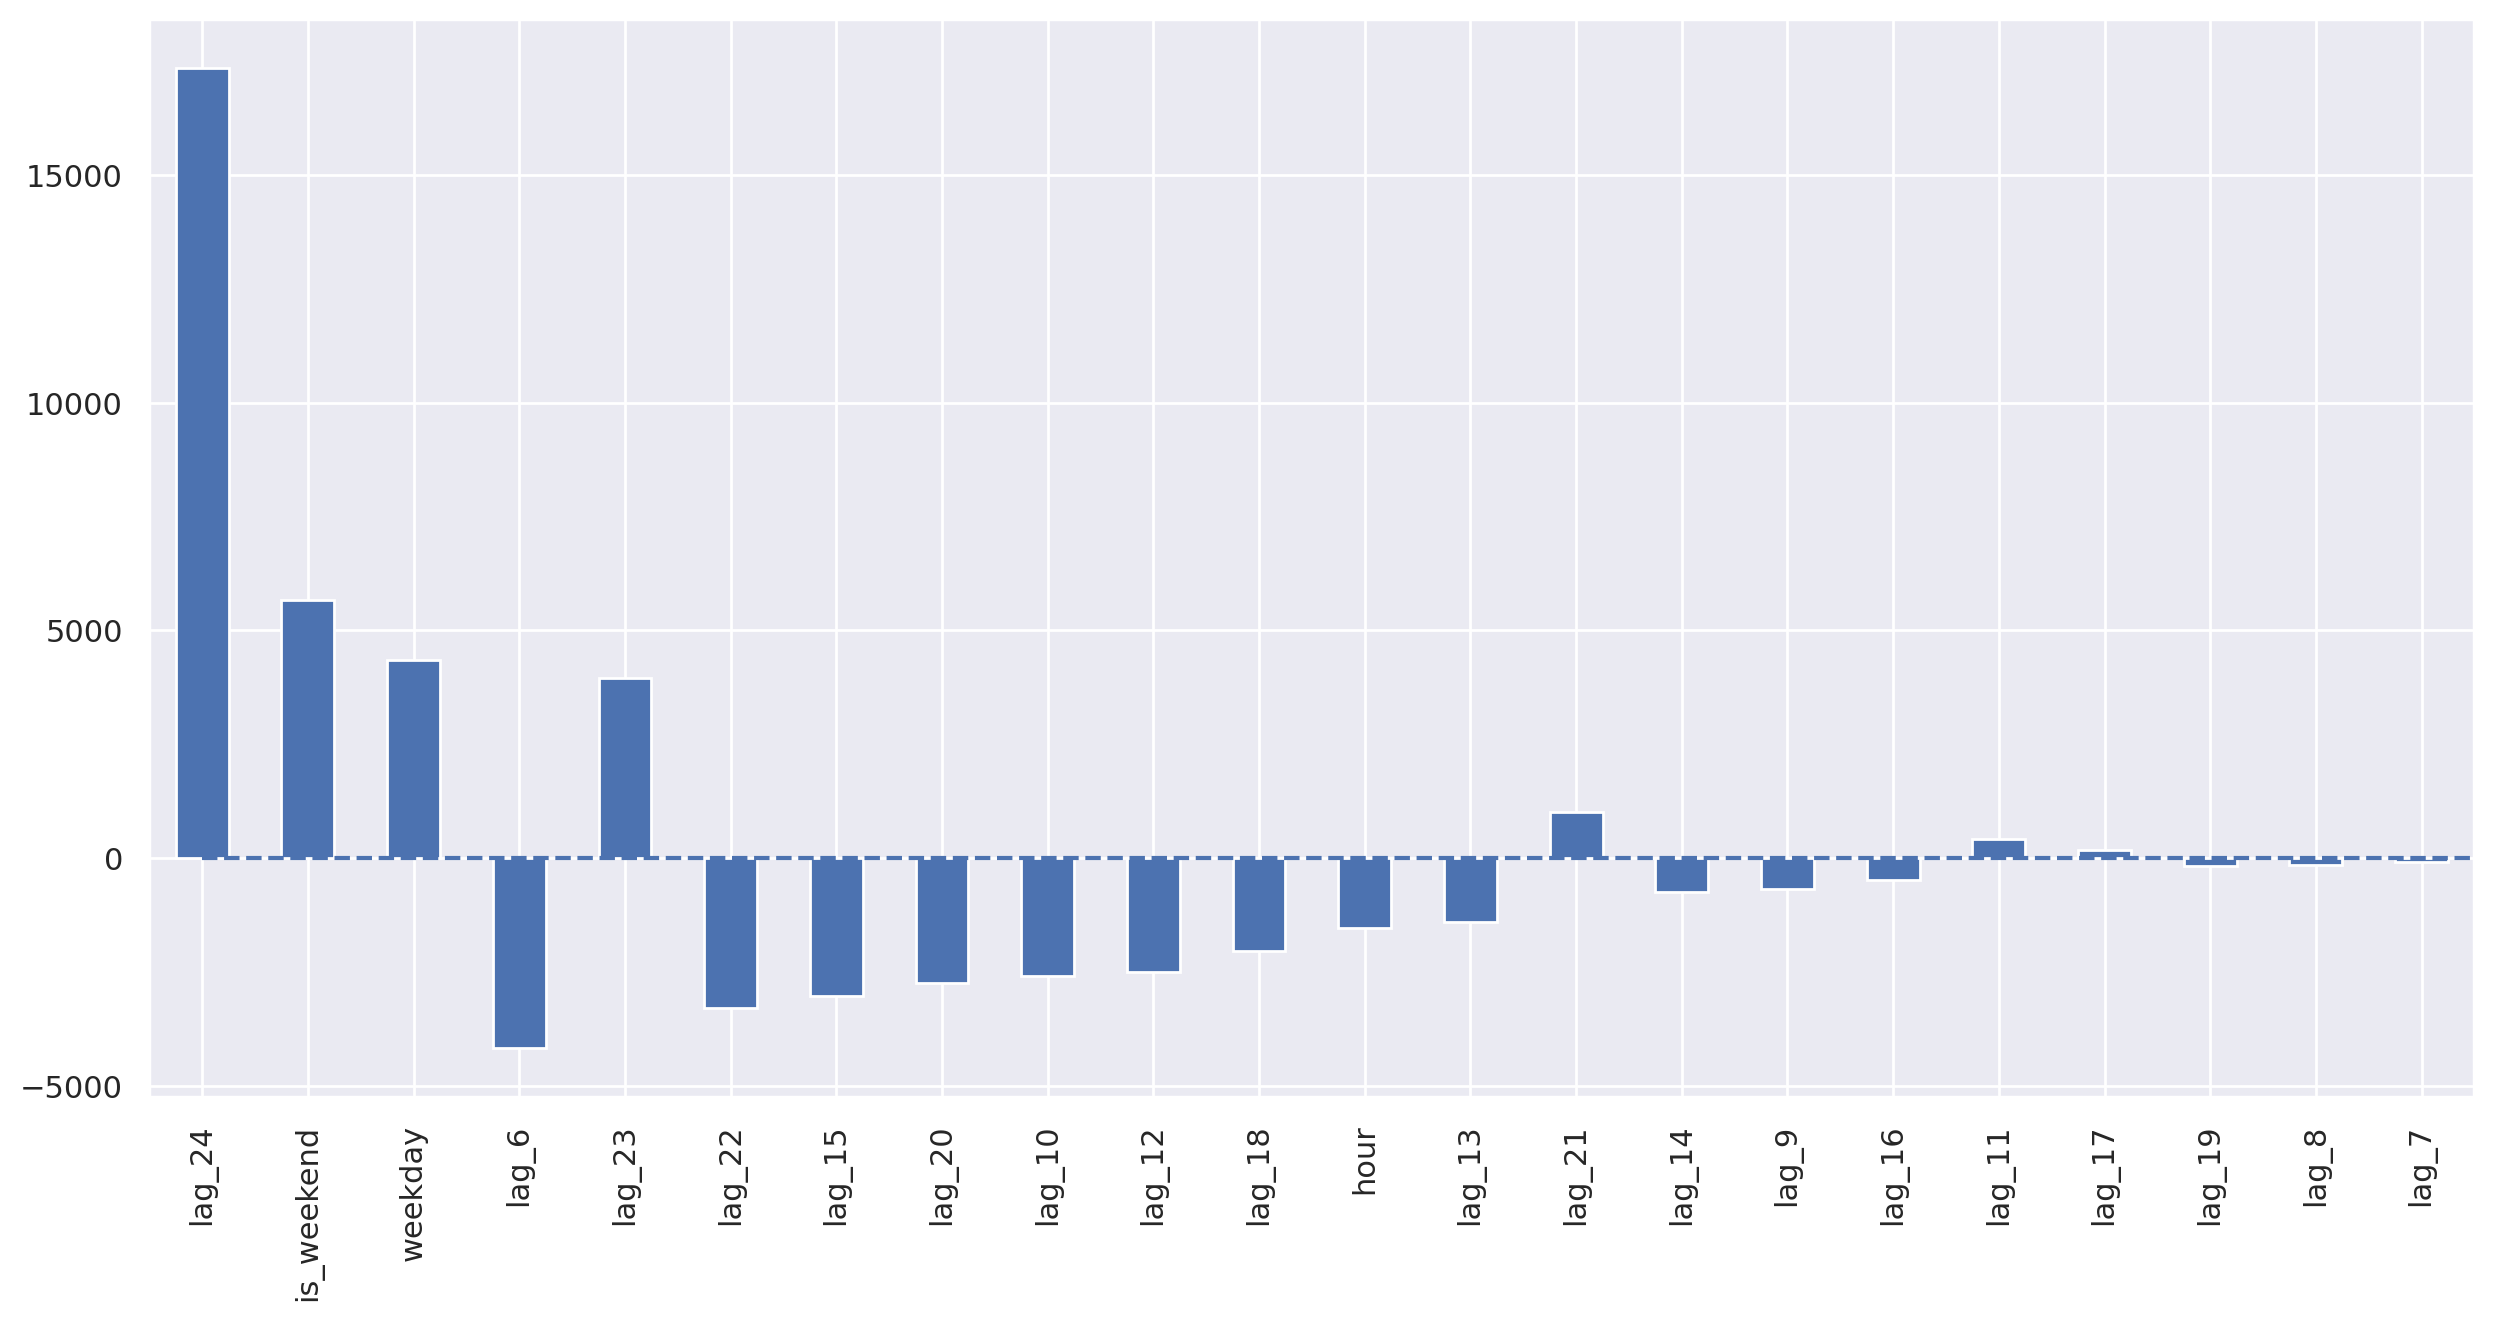

In [20]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

The test error goes down a little bit. Judging by the coefficients plot, we can say that `weekday` and `is_weekend` are useful features.

## Target encoding
I'd like to add another variant for encoding categorical variables: encoding by mean value. If it is undesirable to explode a dataset by using many dummy variables that can lead to the loss of information and if they cannot be used as real values because of the conflicts like "0 hours < 23 hours", then it's possible to encode a variable with slightly more interpretable values. The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

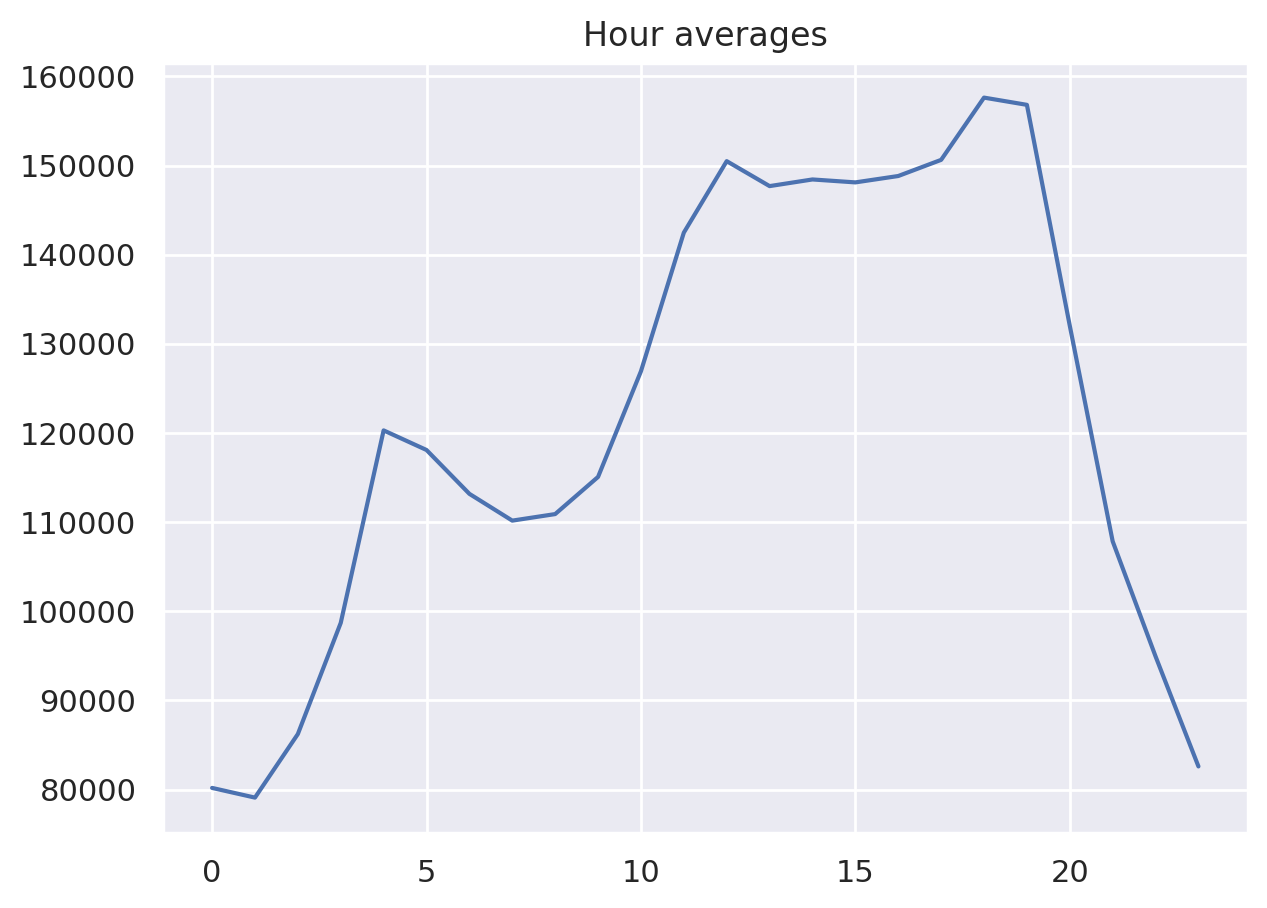

In [21]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

# Let's look at the averages by hour.
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

## (TODO) Let's wrap everything we saw until now and add the hour average :

# /!\ /!\ /!\Some errors that leak information are hidden in this function:

## => find them !

In [23]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable
            example - lag_start = 1 means that the model
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset

    """

    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i) #to complete / already completed
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    if target_encoding:

        data['weekday_average'] = list(map(code_mean(data, 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data, 'hour', "y").get, data.hour))

        # drop encoded variables
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

### If no leak: MAPE should be ~5.81% in next cell

Cross-Validation MAE: 11769.792141750937
Test MAE: 5387.56701907532


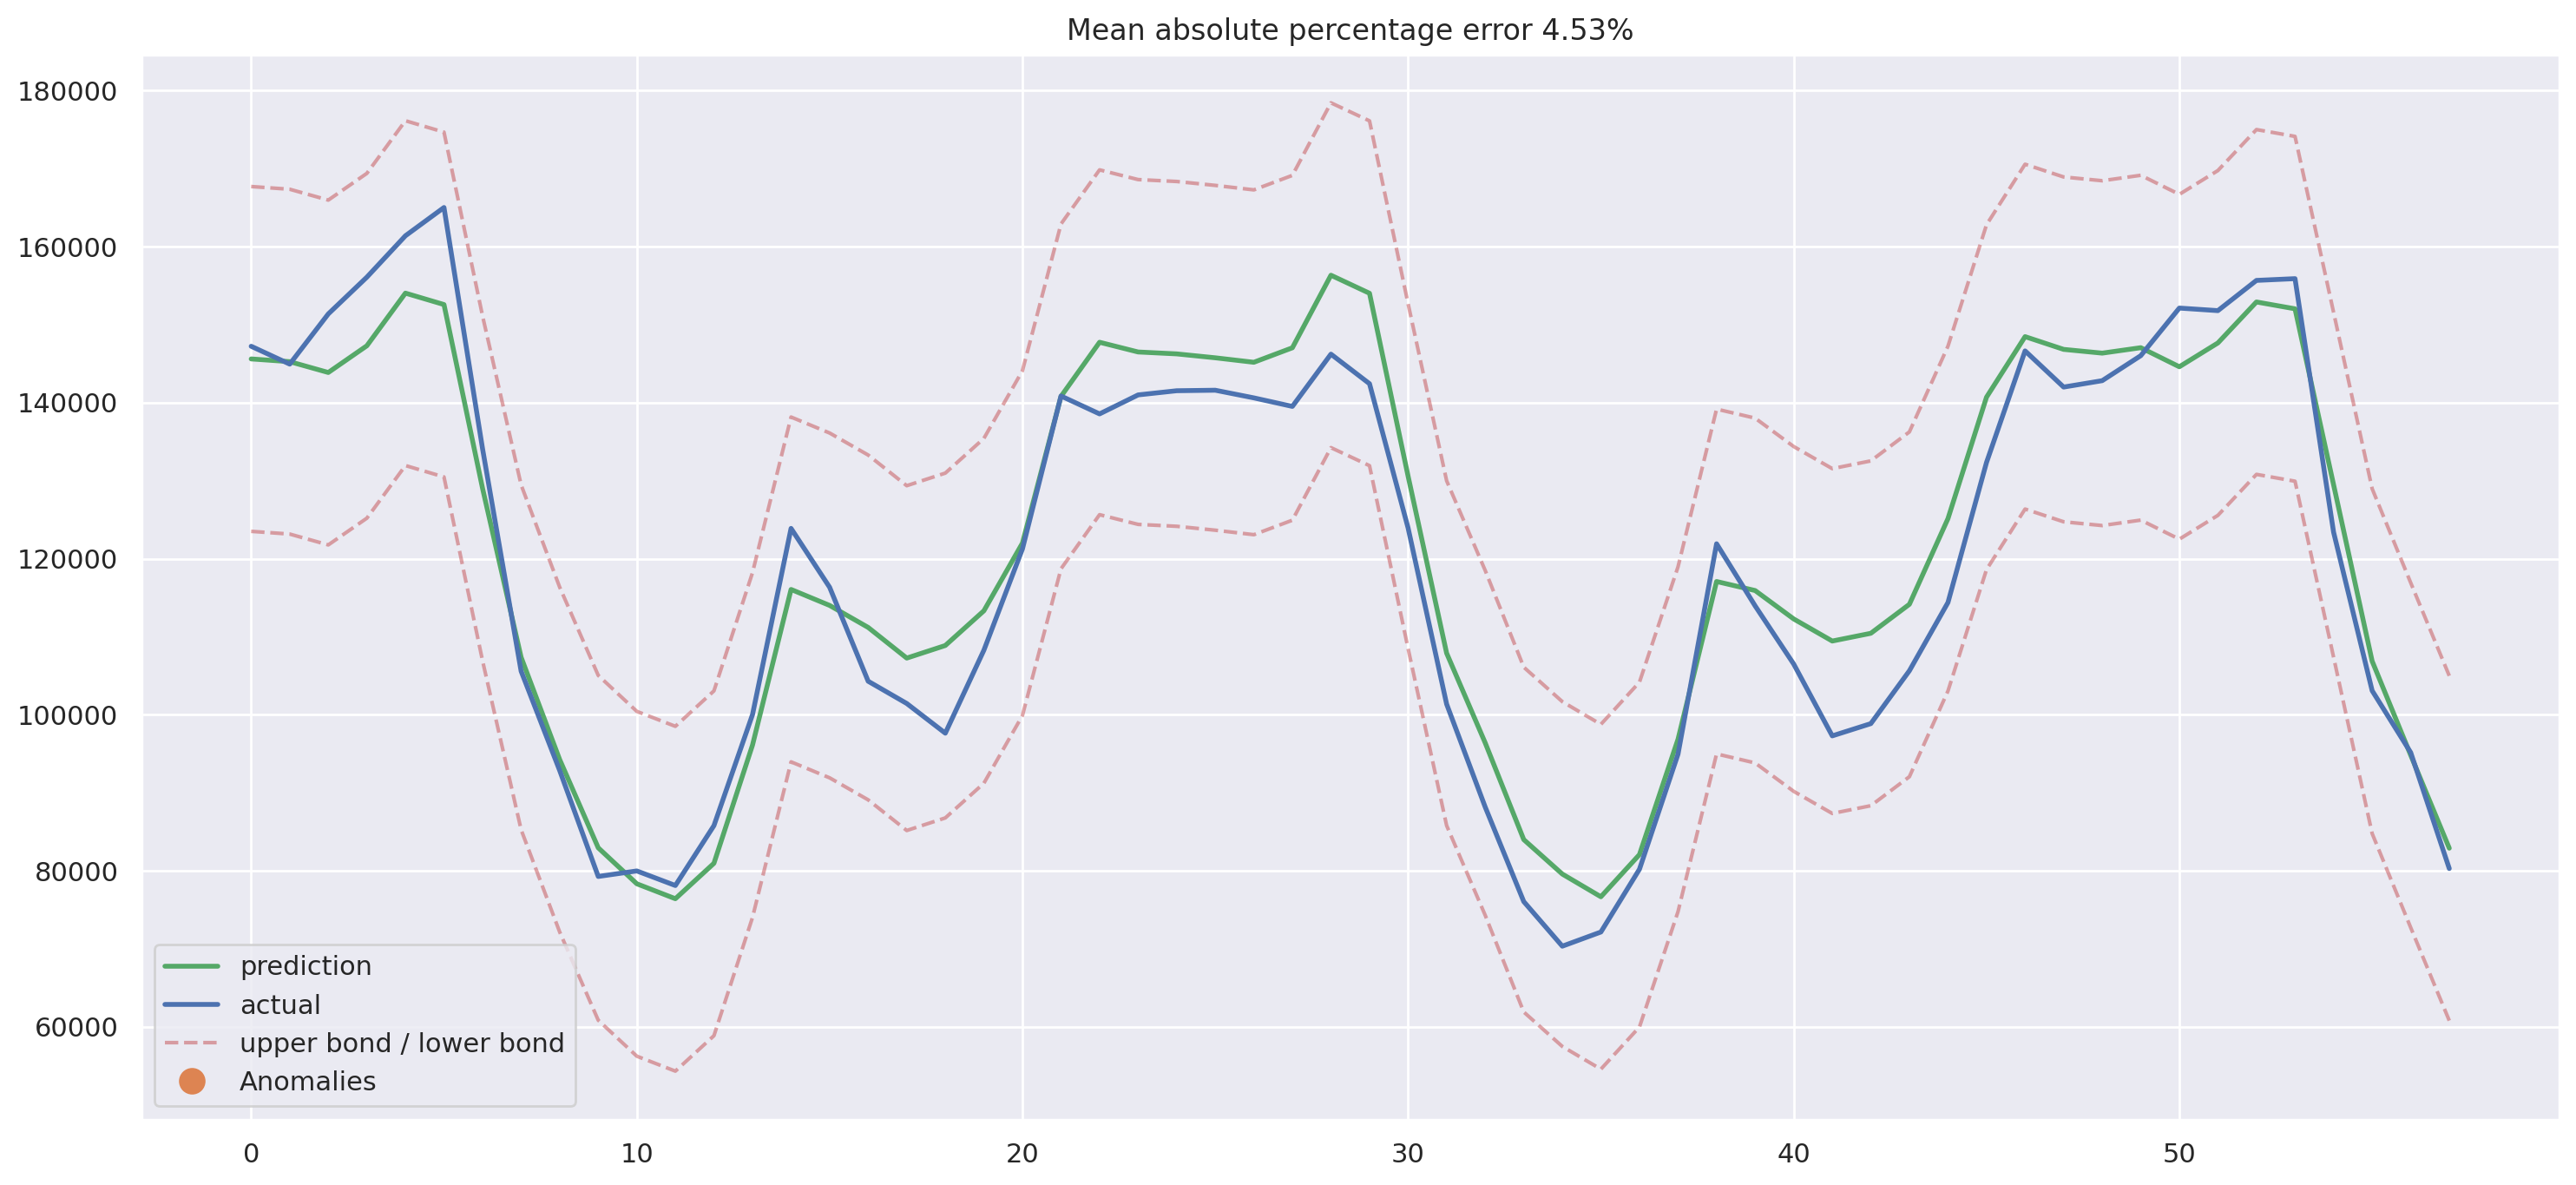

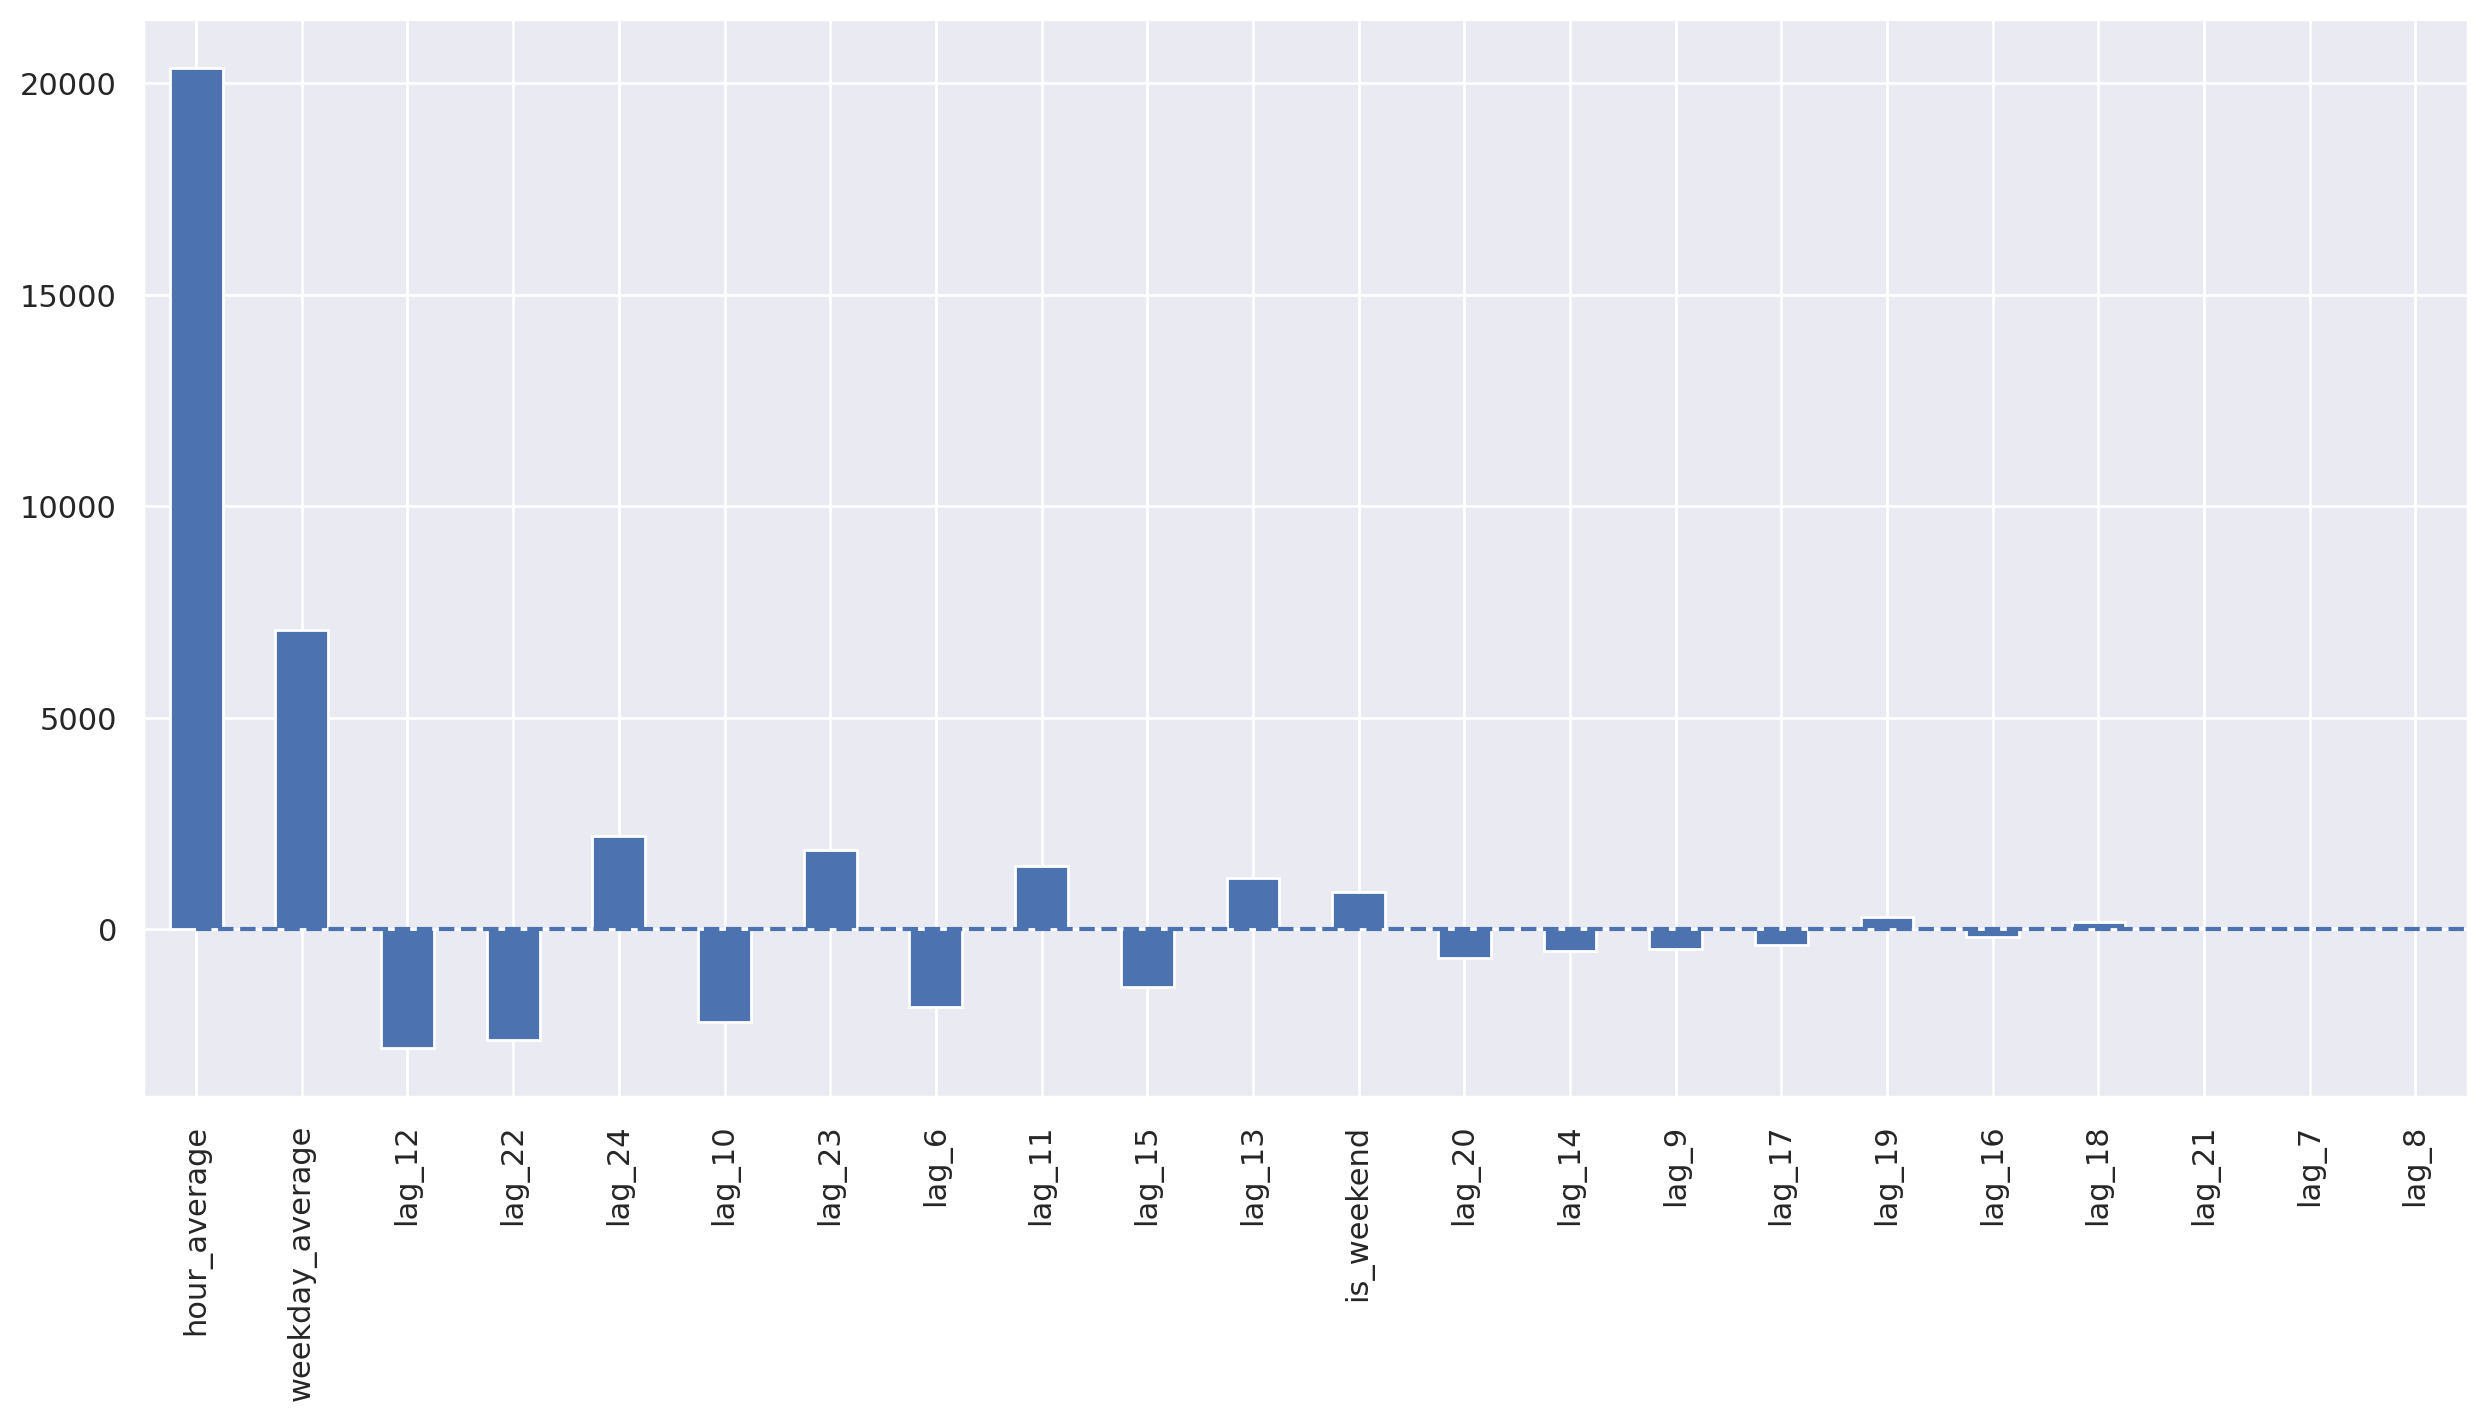

In [24]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

We see some **overfitting**! `Hour_average` was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case.

In [25]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Regularization and feature selection

As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function.

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low.

As a result of this $L2$ regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called $L1$.

First, let's make sure that we have features to drop and that the data has highly correlated features.

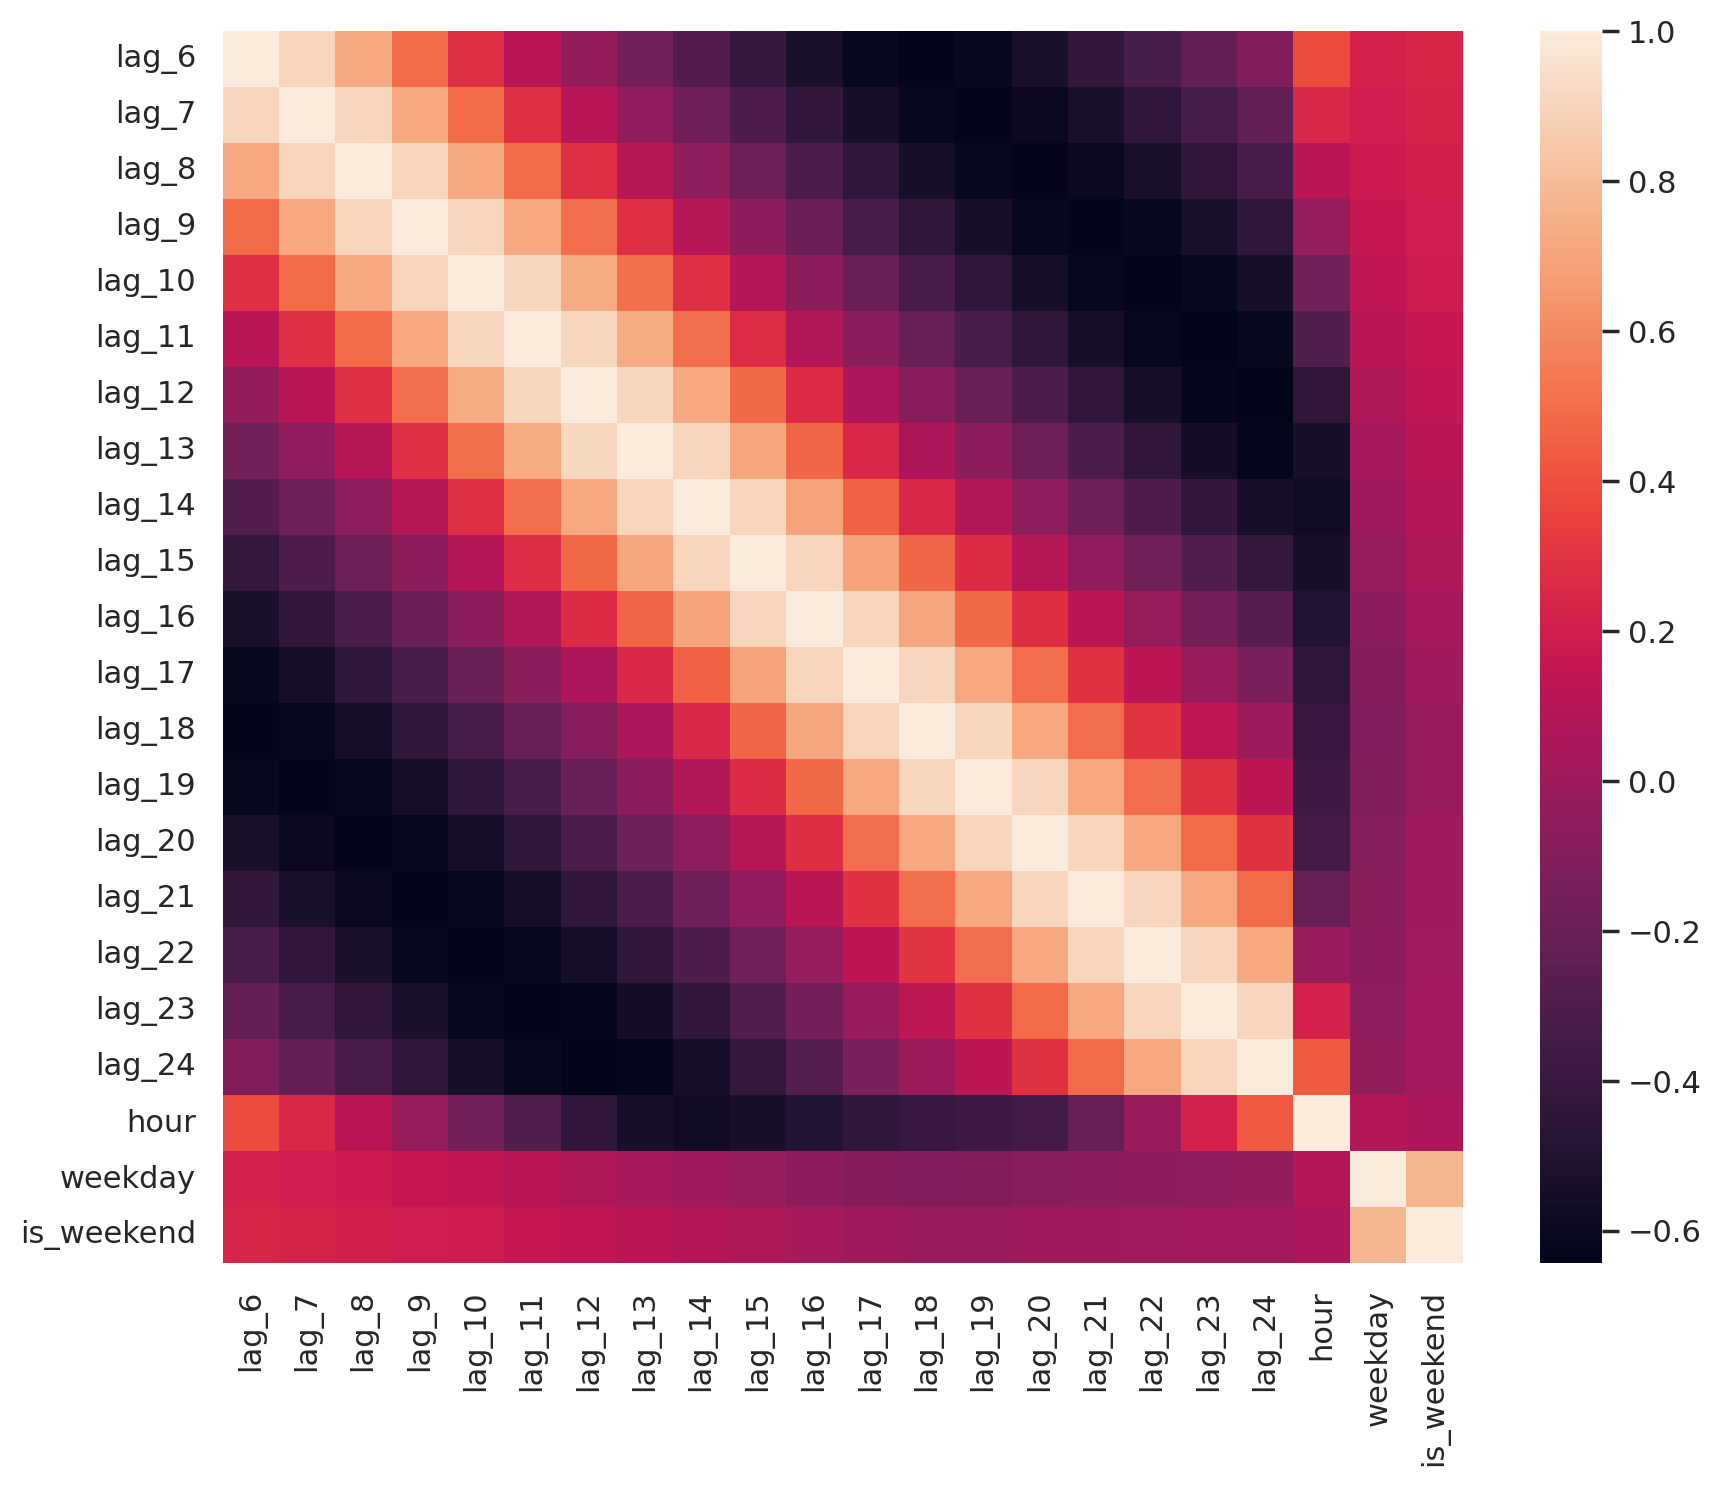

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

Cross-Validation MAE: 10066.097119325801
Test MAE: 6757.624122952902


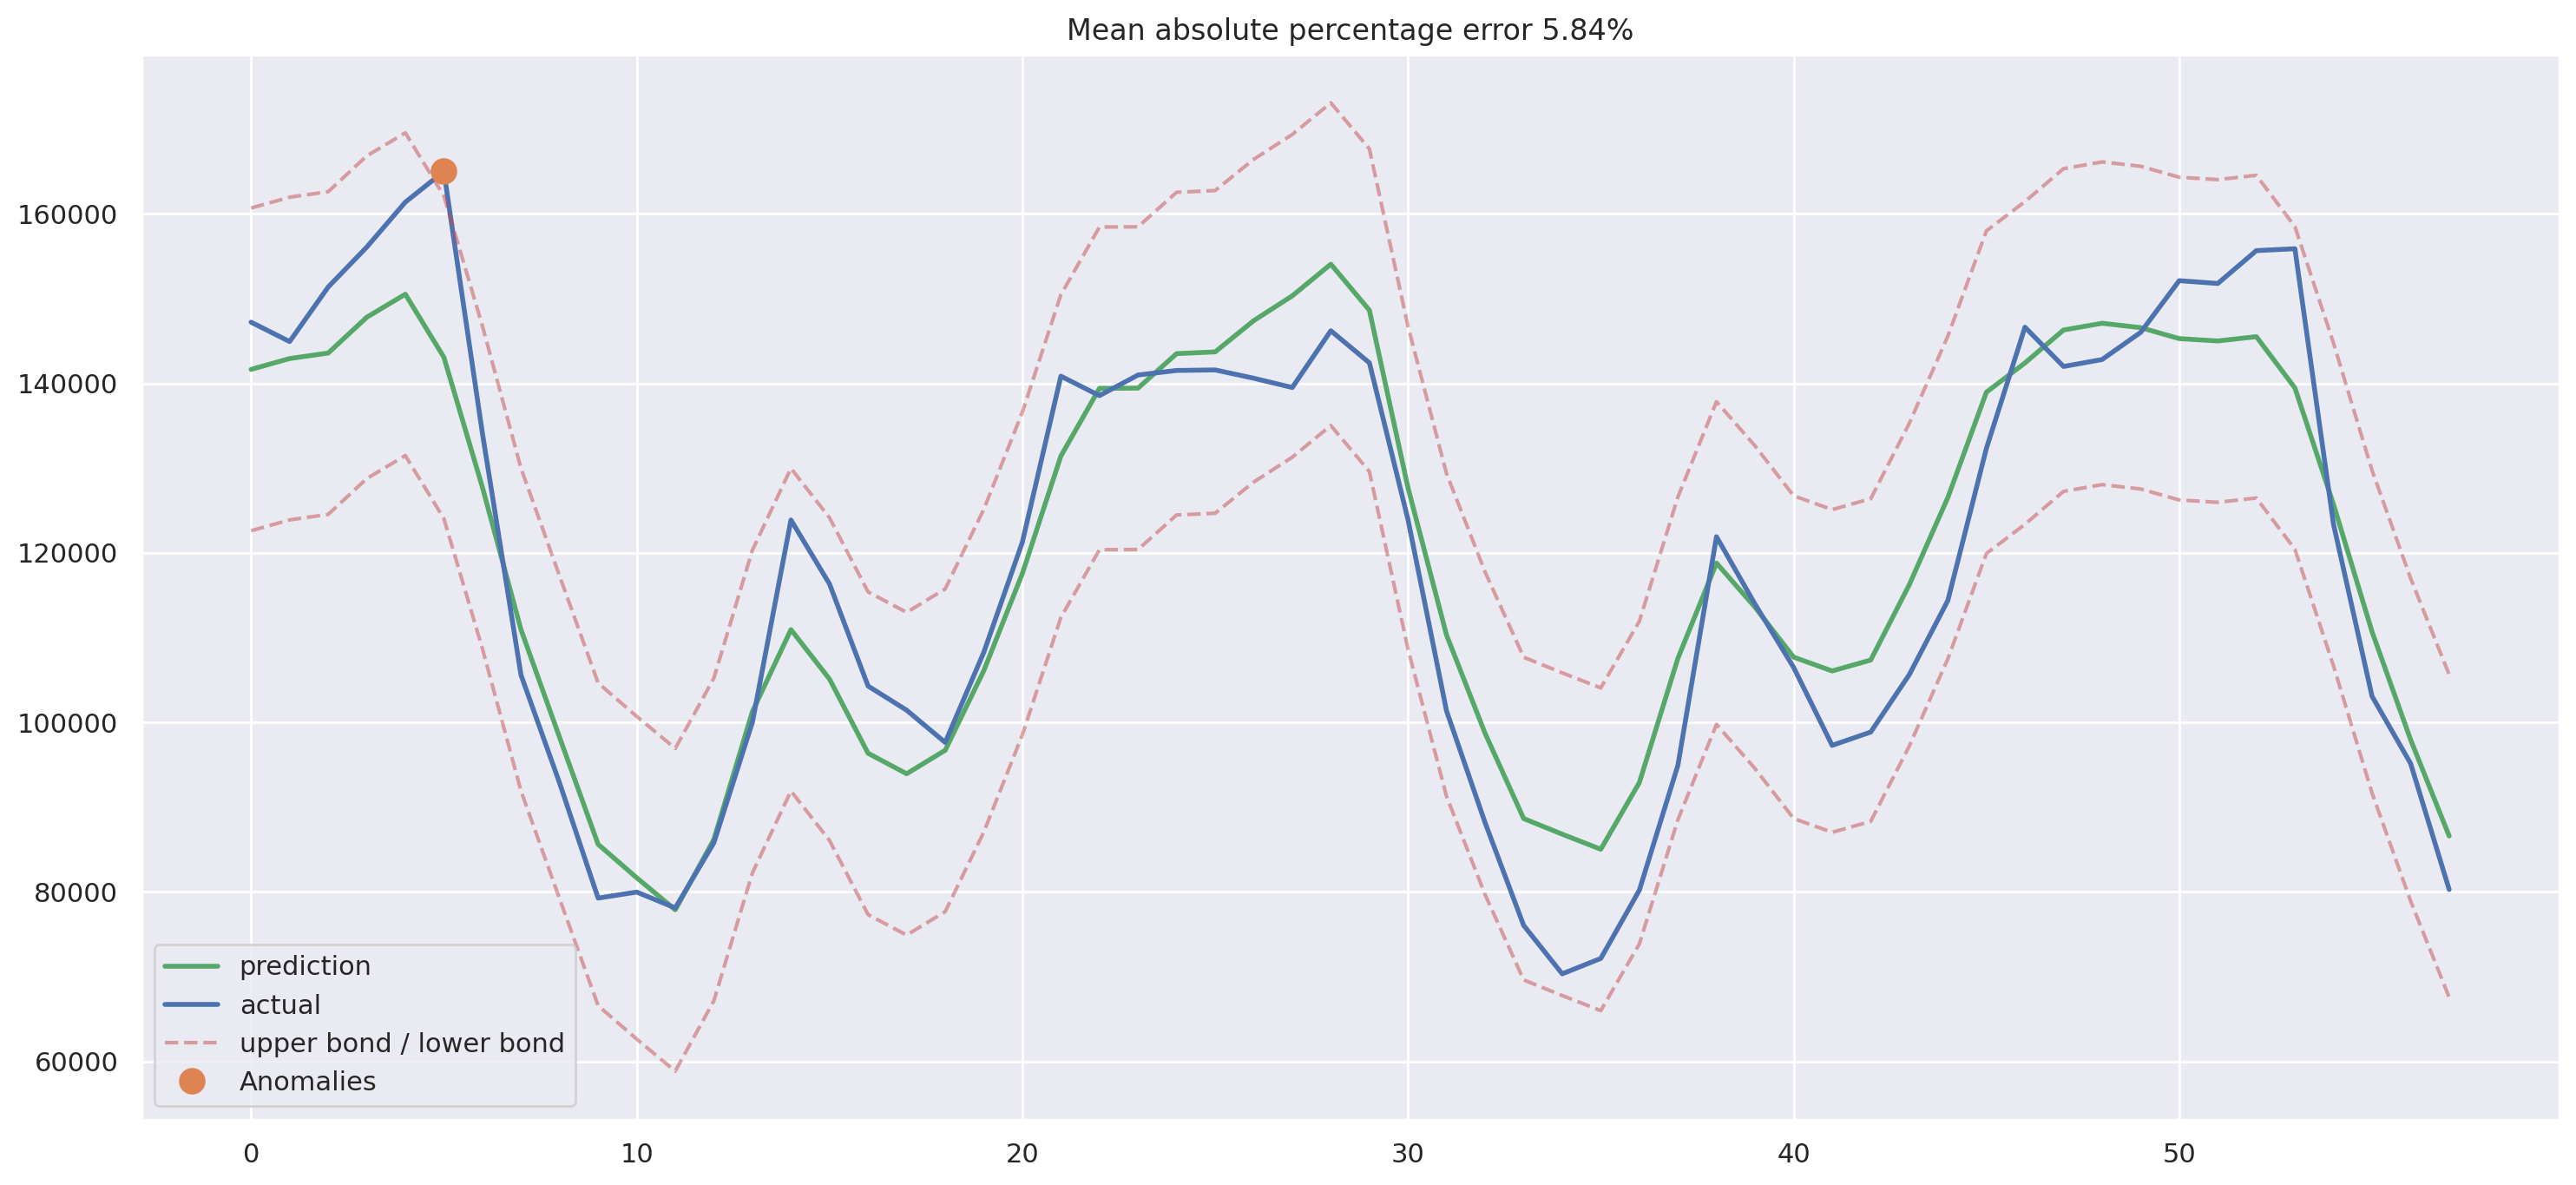

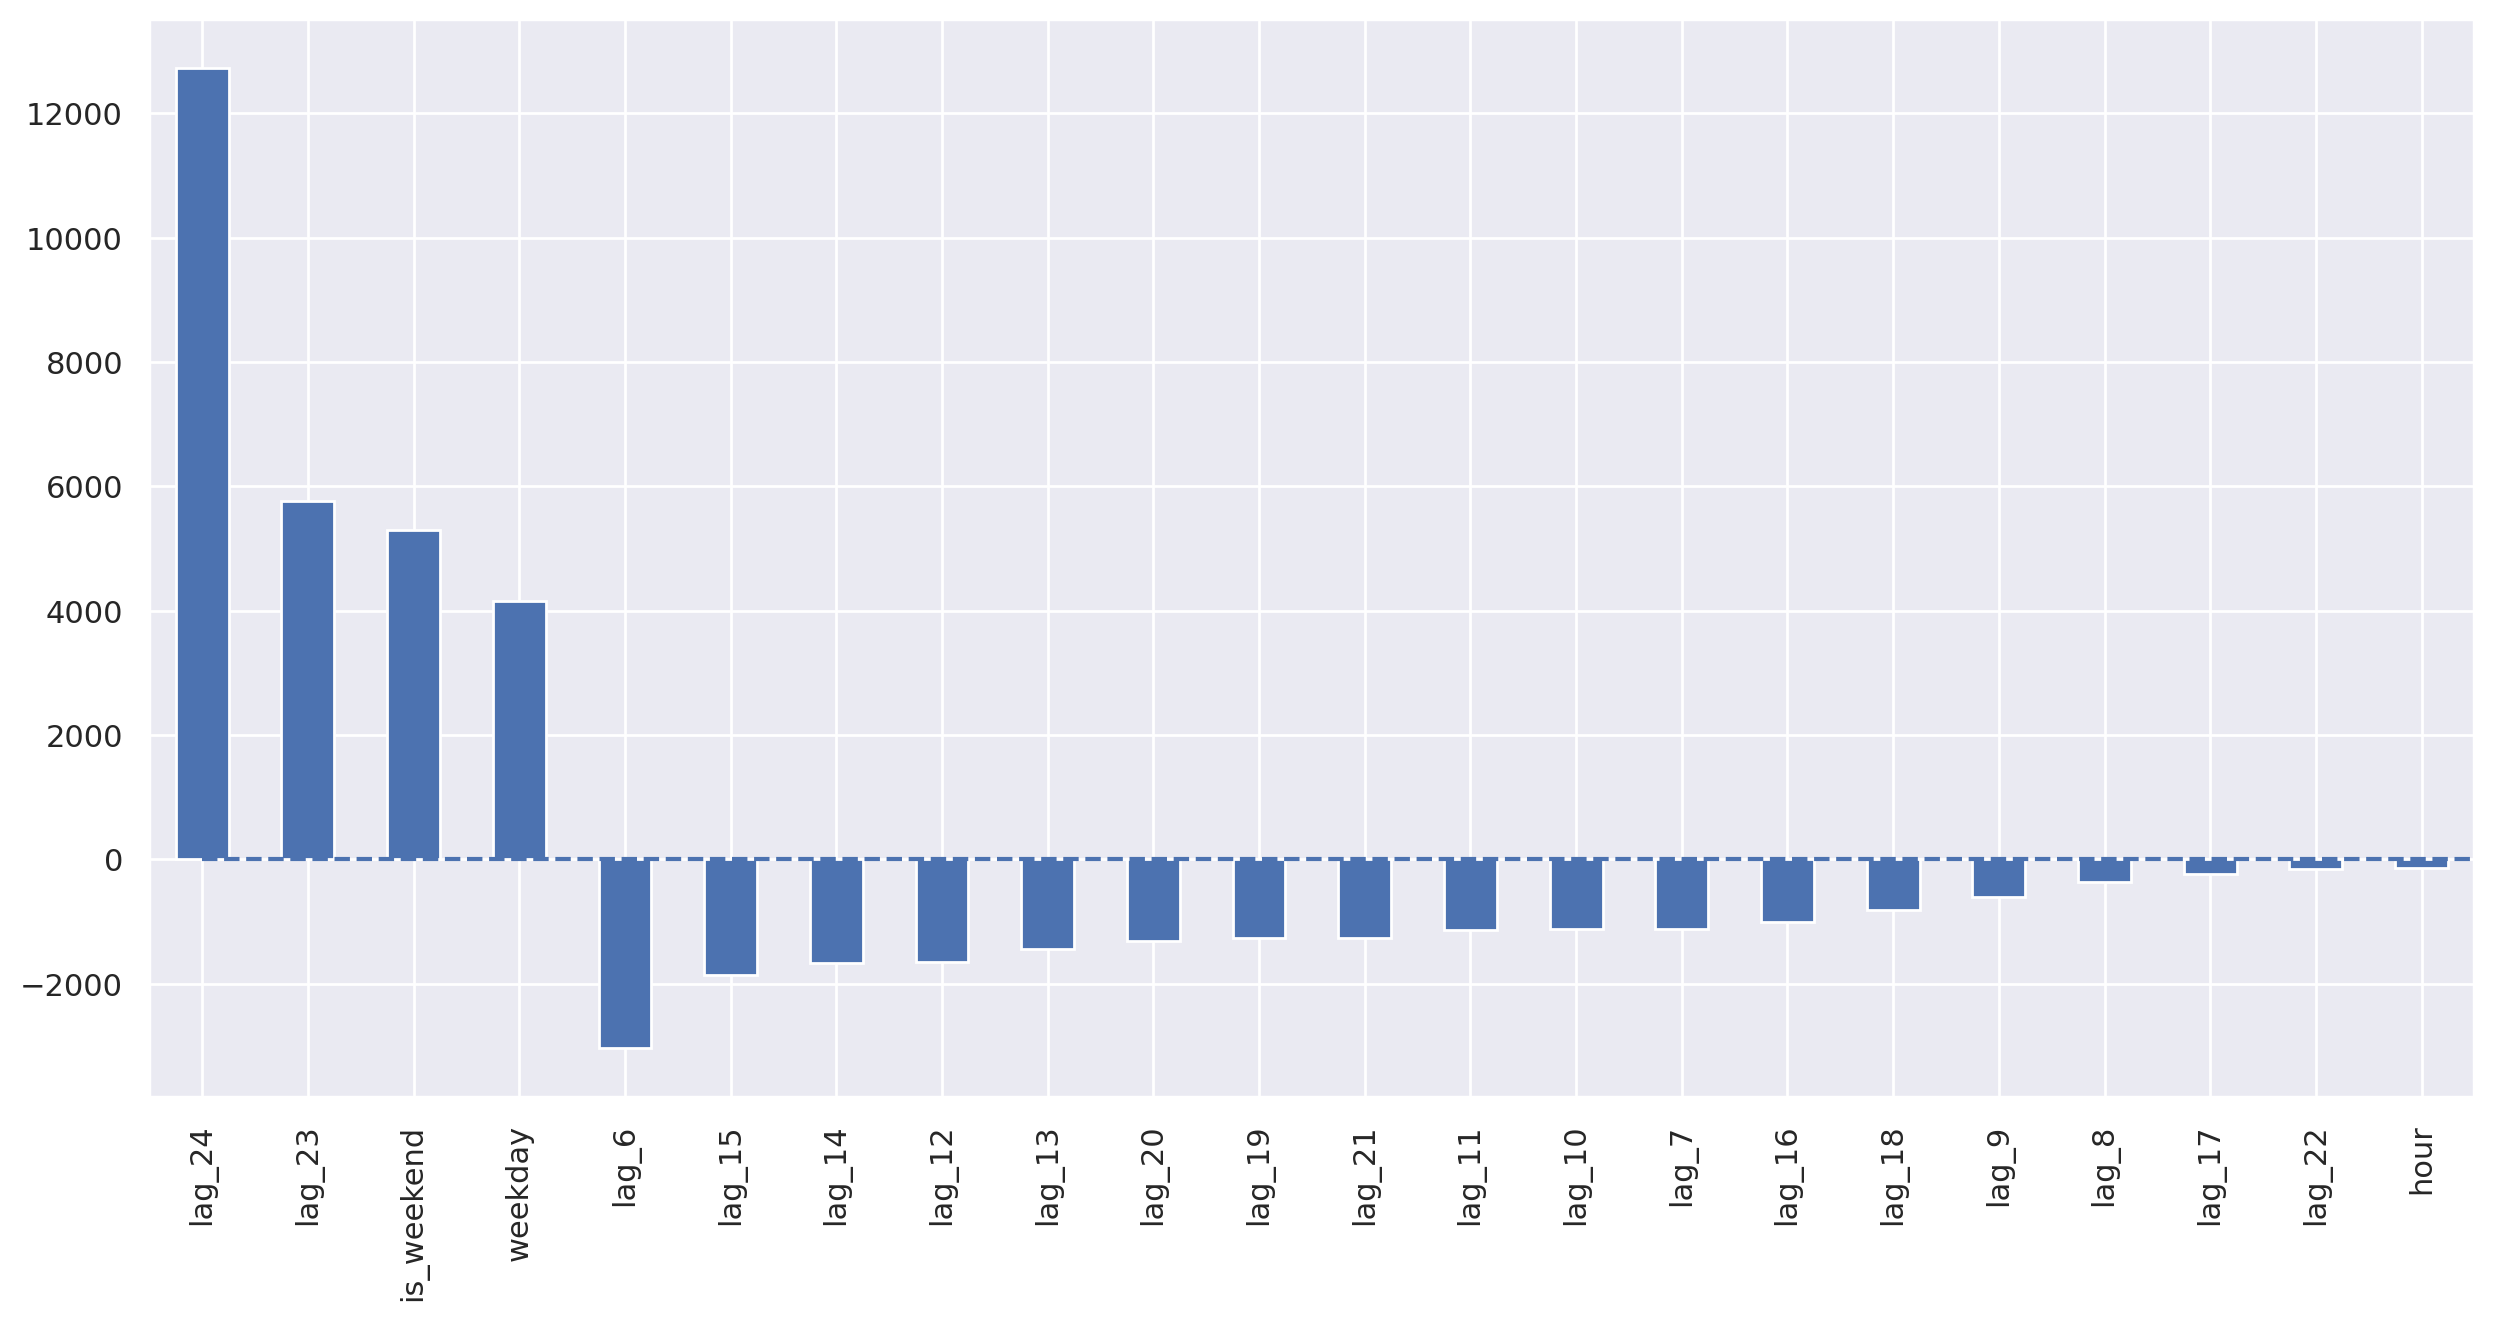

In [31]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=TimeSeriesSplit(n_splits=5))
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)



## (TODO) One sneaky error is in the following cells: can you spot it ?

# /!\ Find the sneaky ERROR /!\

We can clearly see some coefficients are getting closer and closer to zero (though they never actually reach it) as their importance in the model drops.

Cross-Validation MAE: 10583.357778821039
Test MAE: 6409.871331982593


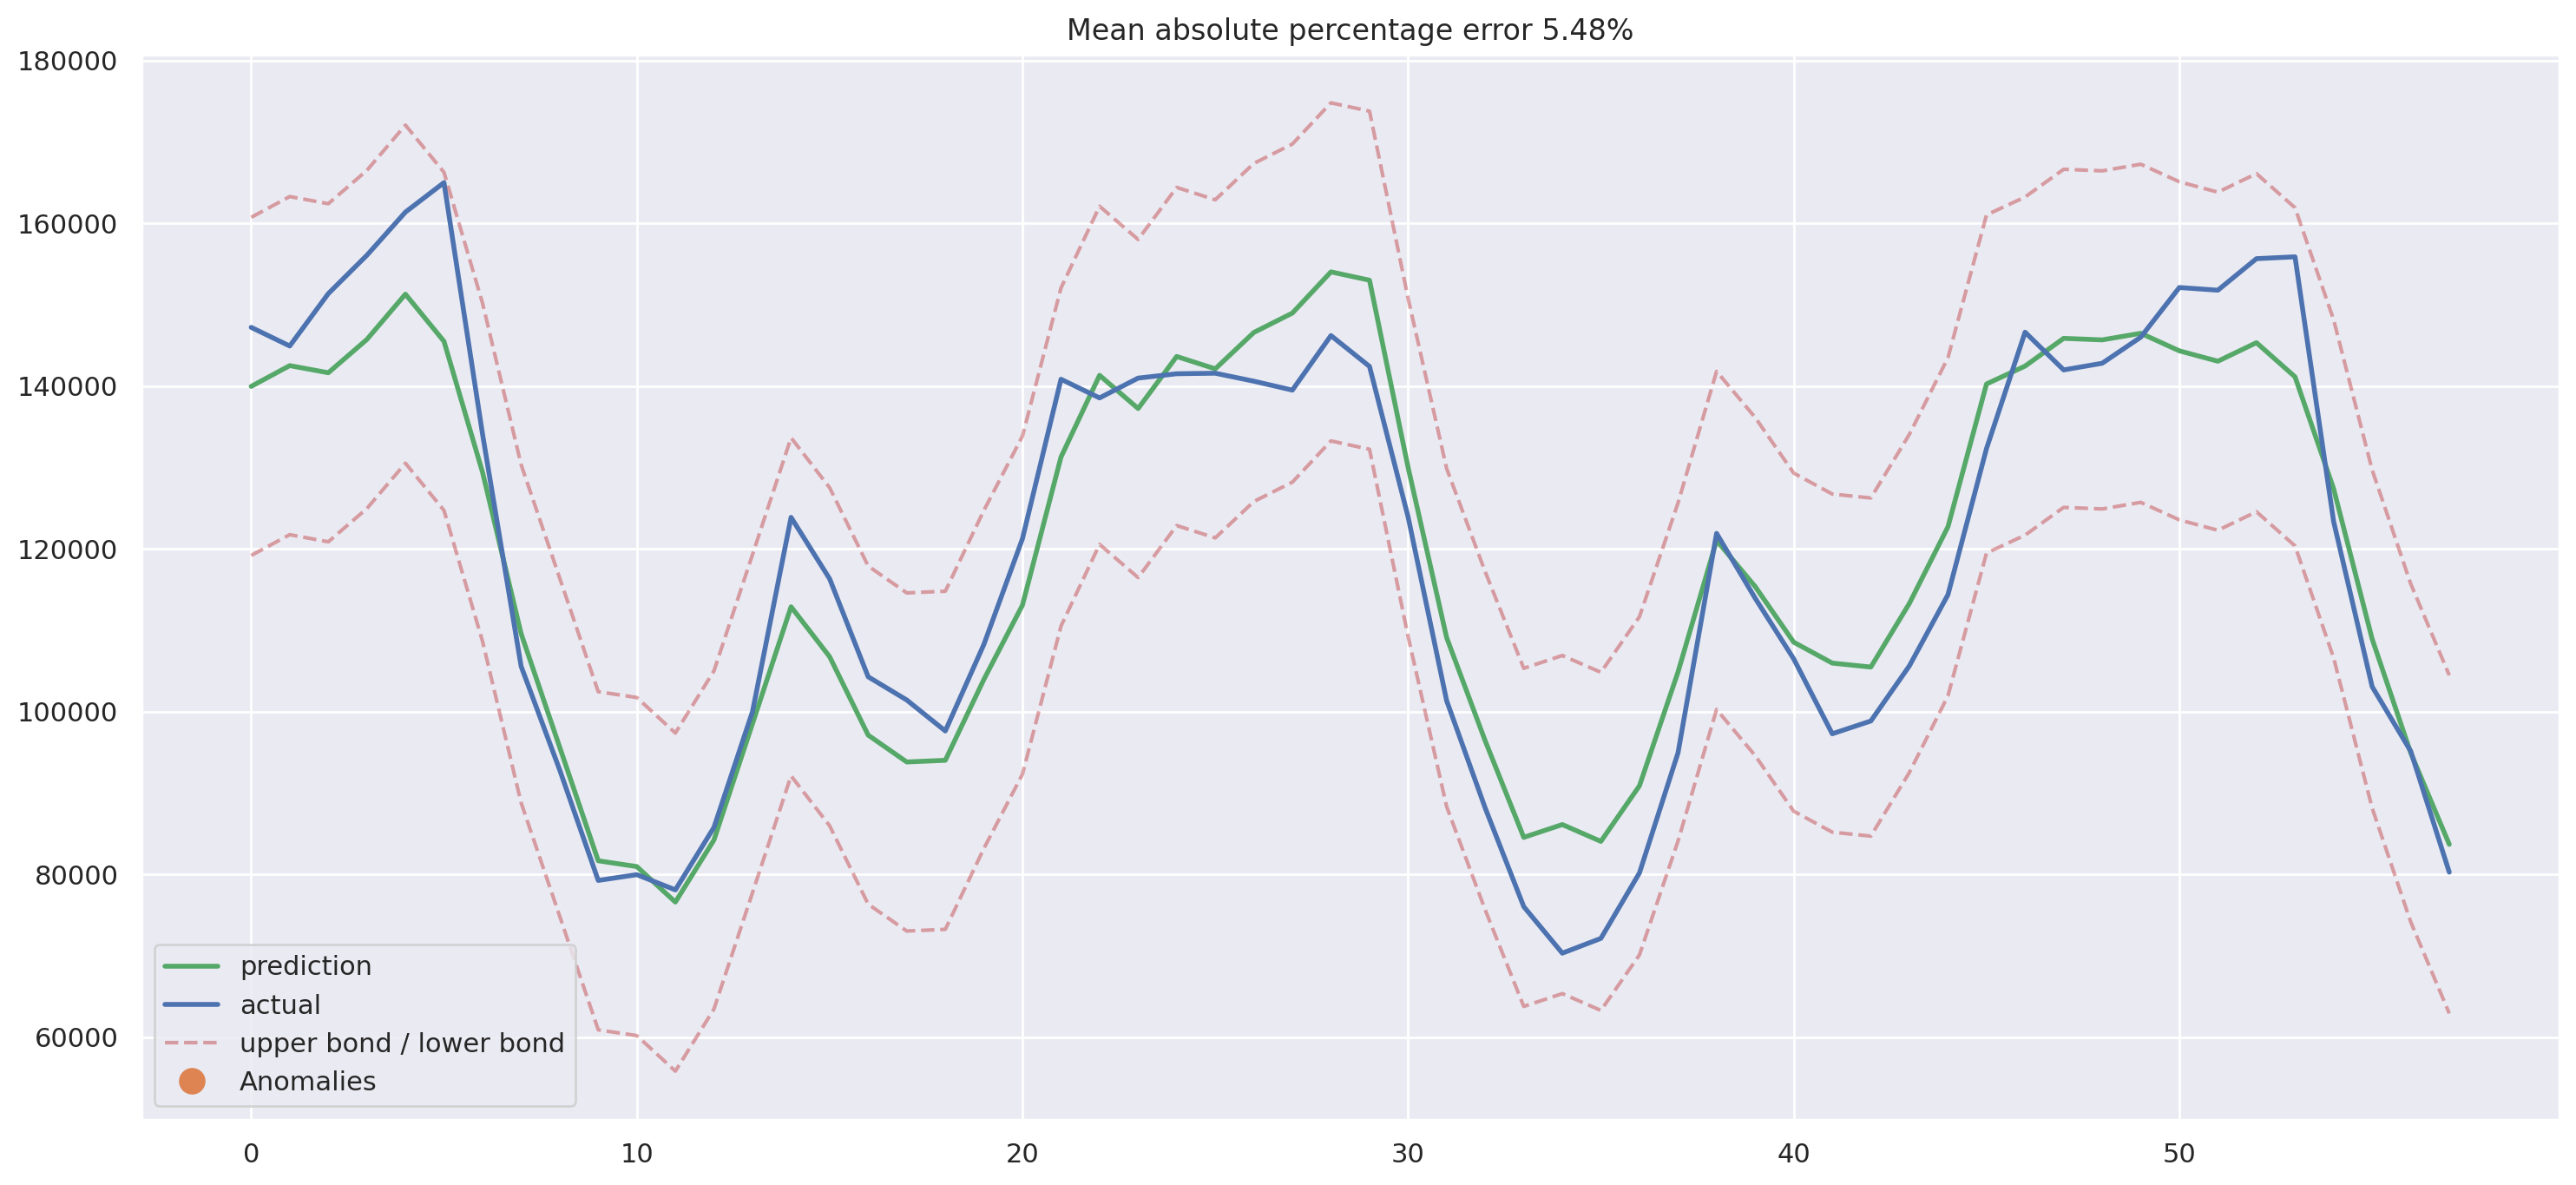

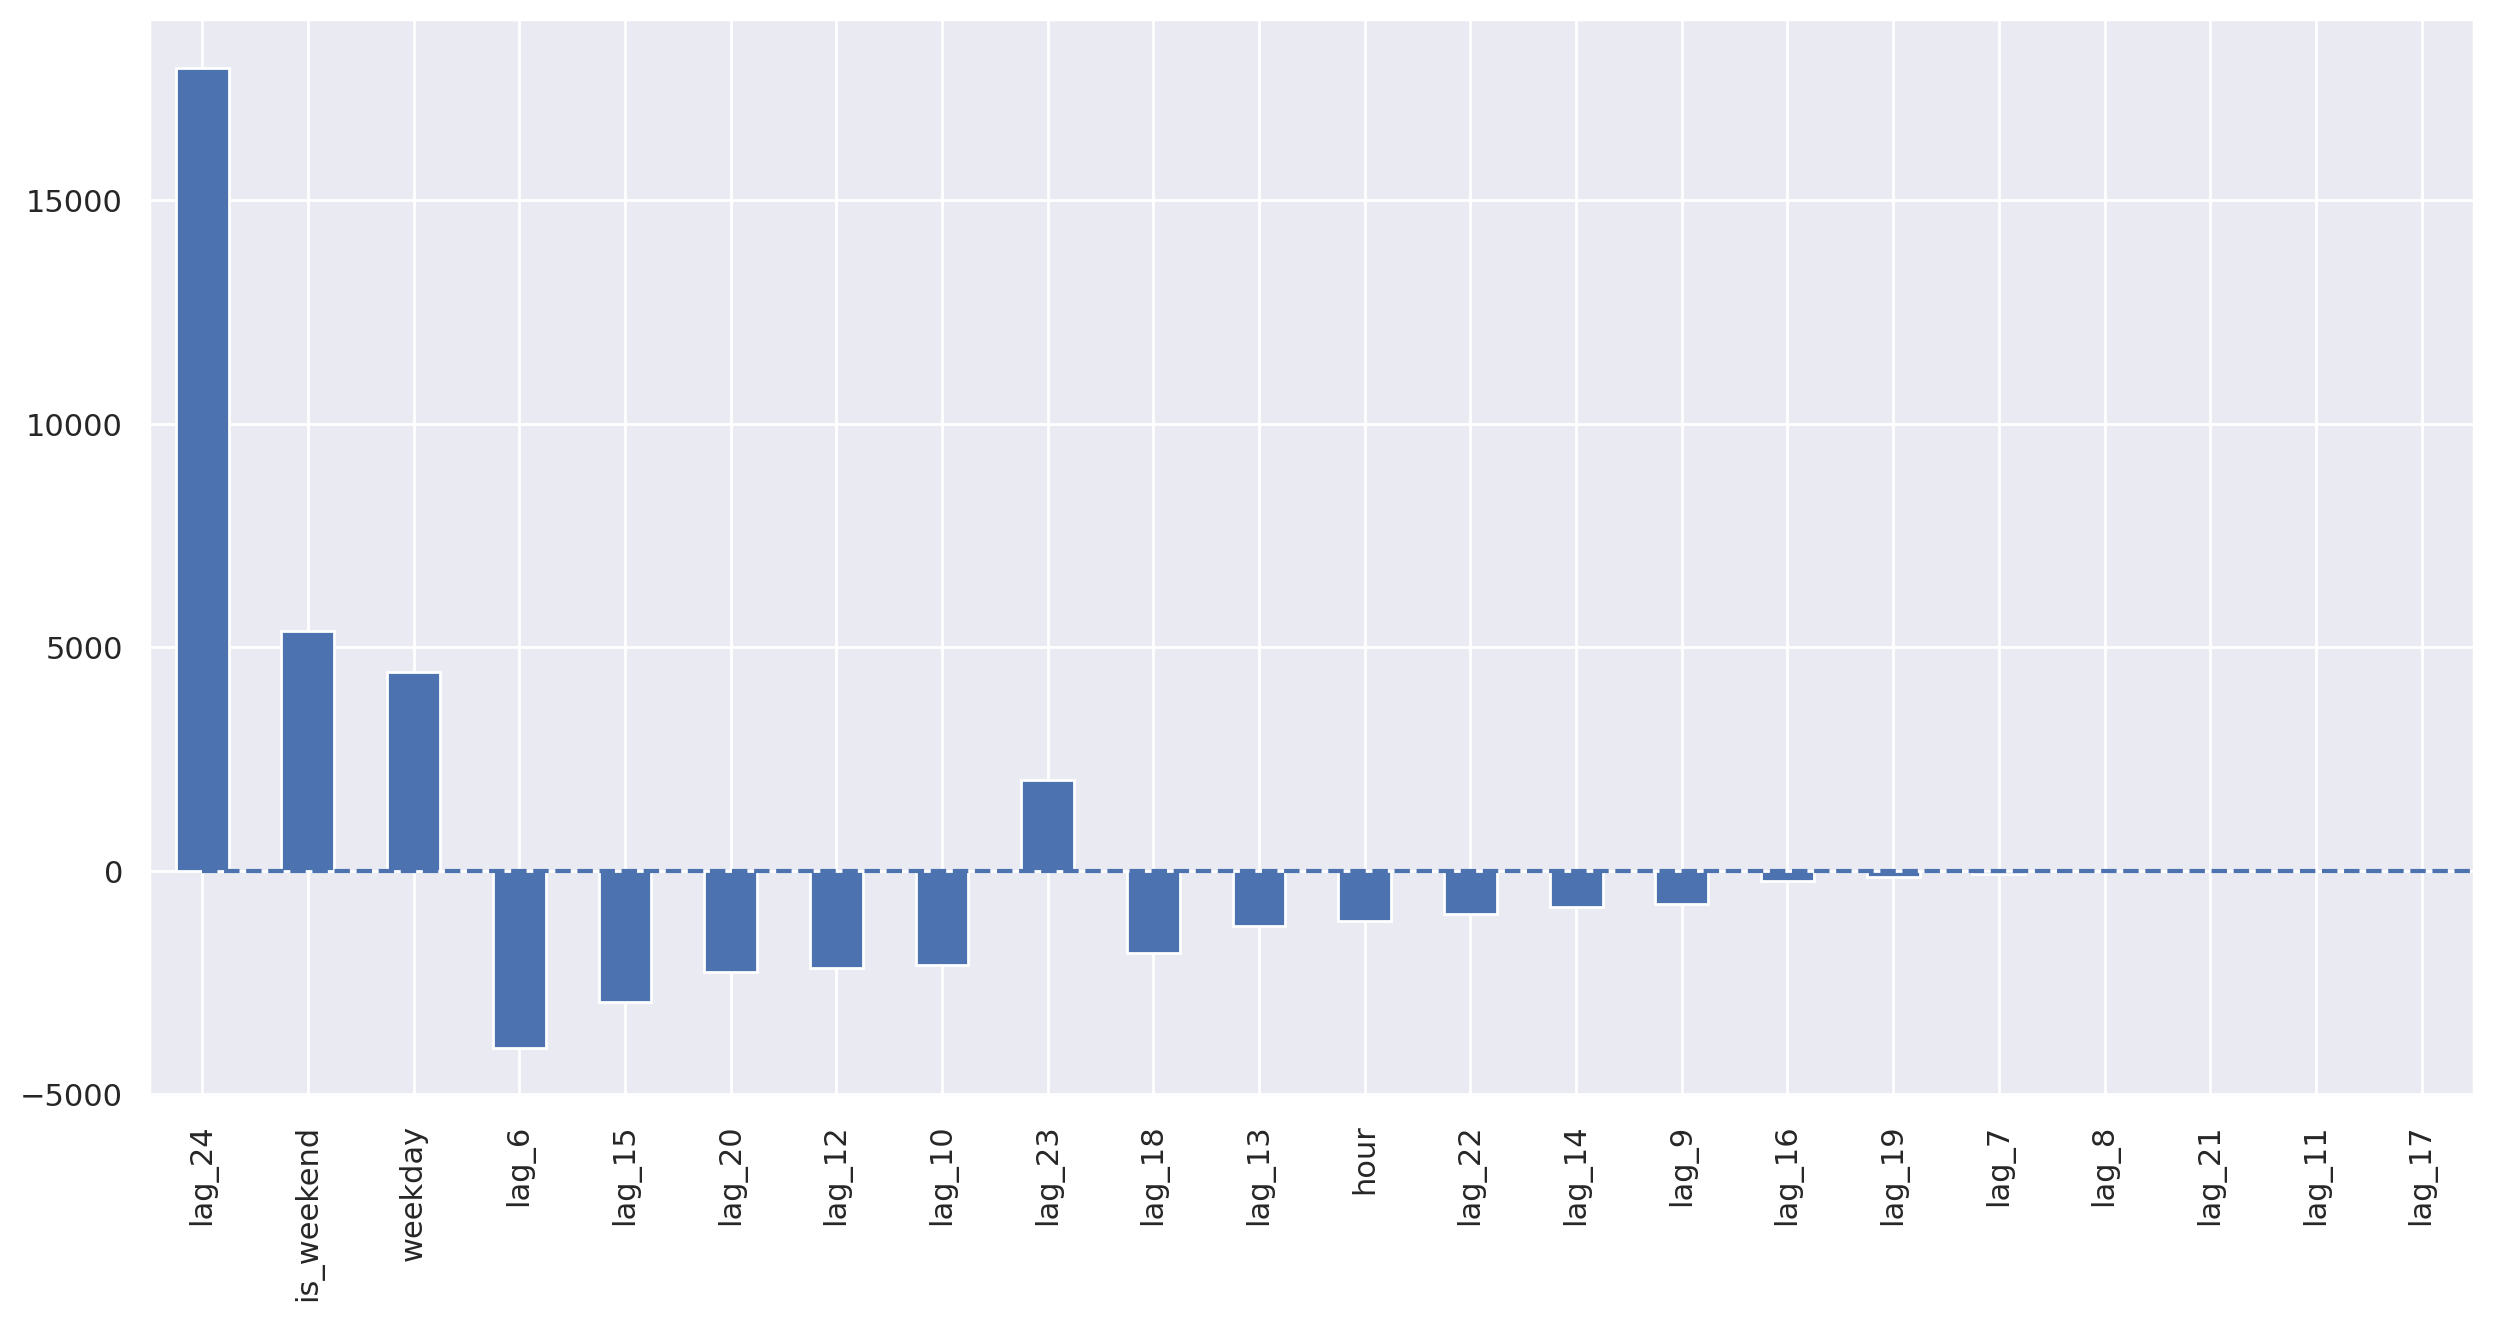

In [33]:
lasso = LassoCV(cv=ShuffleSplit(n_splits=5))
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Lasso regression turned out to be more conservative; it removed 23-rd lag from the most important features and dropped 5 features completely, which only made the quality of prediction better.

# Boosting
Why shouldn't we try XGBoost now?



Cross-Validation MAE: 10433.951917613635
Test MAE: 4994.250269396552


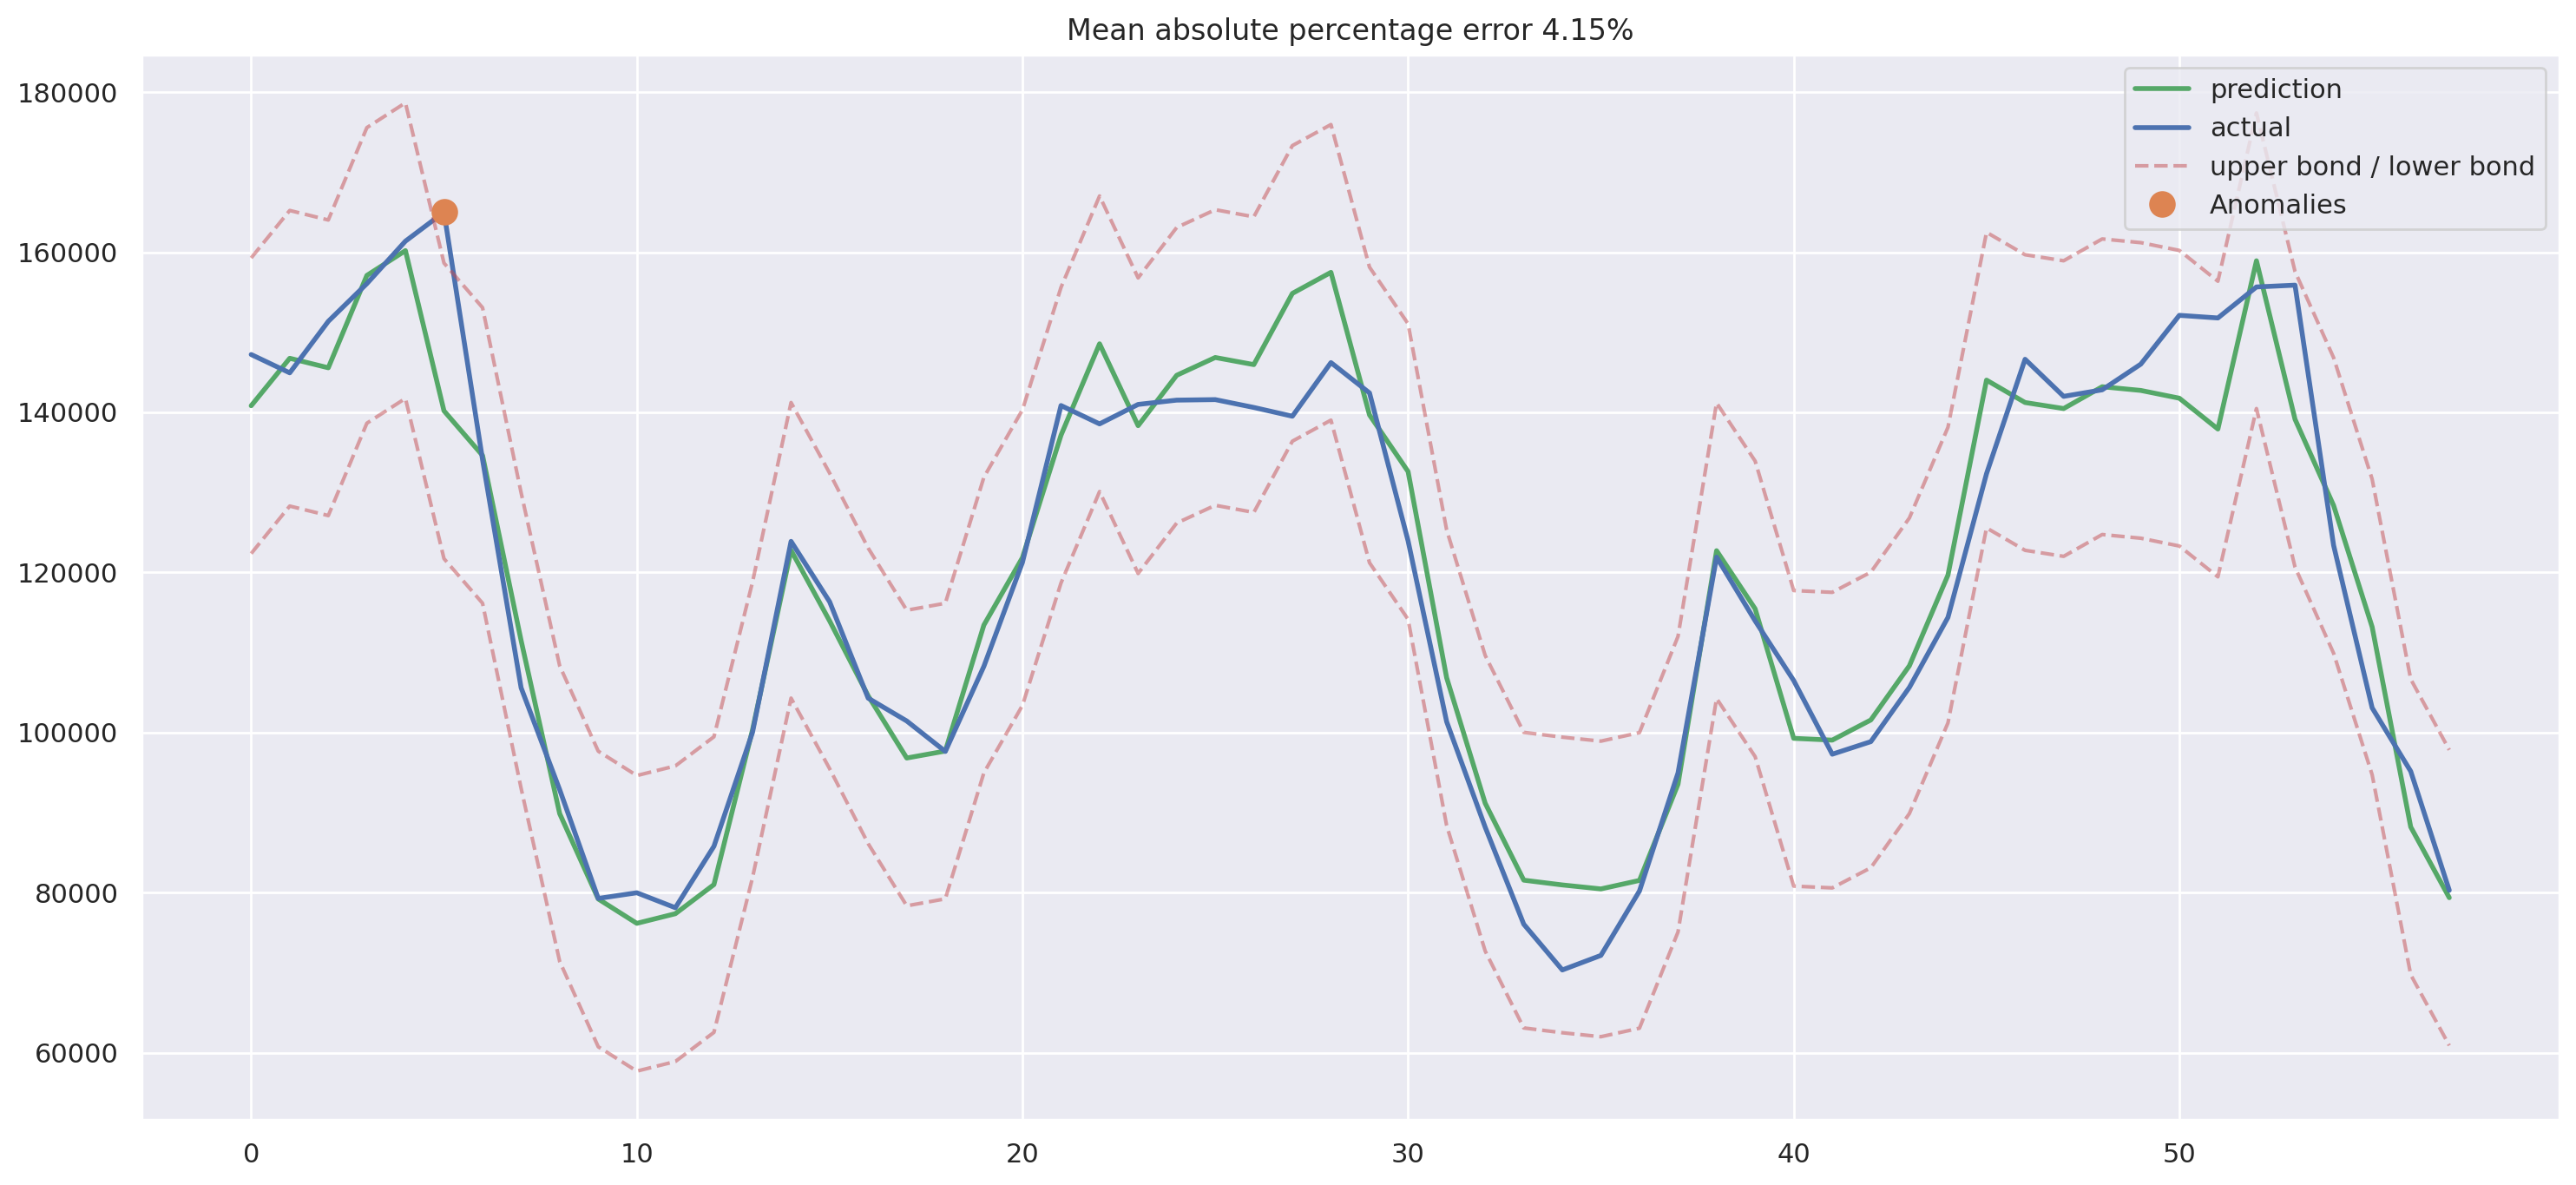

In [34]:
from xgboost import XGBRegressor

xgb = XGBRegressor(verbosity=0)
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)

We have a winner! This is the smallest error on the test set among all the models we've tried so far.

But, this victory is decieving, and it might not be the brightest idea to fit `xgboost` as soon as you get your hands on time series data. Generally, tree-based models handle trends in data poorly when compared with linear models. In that case, you would have to detrend your series first or use some tricks to make the magic happen. Ideally, you can make the series stationary and then use XGBoost. For example, you can forecast trend separately with a linear model and then add predictions from `xgboost` to get a final forecast.

* [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276) - one of a few cases where using random forest for time series forecasting is actively defended

## Takeaways

We discussed different time series analysis and prediction methods. We showed that Time series manipulation while a simple linear regression model can be built in 10 minutes and can achieve more or less comparable results.

### Keep in mind

However, when feature building, it is **REALLY** important to take care of where features: they must not include data from the target which would not be know at test time.

# Your turn !

## (a) Data

You are provided with daily historical sales data.

### >> The task is to forecast the total amount of products sold next weeks.
   
   - **date** => The time
   - **item_price** => The mean item price throuh the time
   - **item_id** => The count of sold items through the time
   - **shop_id** => The count of shops opens through time
   
   - **item_cnt_day** => The quantity to forecast: total items sold


In [35]:
newds = pd.read_csv("https://raw.githubusercontent.com/vguigue/TimeSeries/main/data/sales2.csv",parse_dates=["date"])

## Train data:

In [ ]:
train = newds[:608]
train.head()

In [ ]:
train.set_index("date").resample("M").sum().plot()

## What to predict:

In [ ]:
test = newds.loc[608:,["item_cnt_day","date"]]
test.head()

In [ ]:
test.set_index("date").resample("M").sum().plot()

## Your turn:

### =>Follow the previous pointers

## Todo: Time lag

In [ ]:
# To Complete

## Todo: Target Variable

In [ ]:
# To Complete

## Todo: Linear Predictor and XGBoost

In [ ]:
# To Complete


# Finally, let's do a simple timeseries classification task:

Forecast is not the only thing that can be done with Timeseries. Sometimes, you have some sensor data and you want to classify it. Here, we propose to take the bike data from last practical and see if, given one day of bikes rental count, we're able to know the day of the week.

## (a) Loading data with read_csv:

We do two specific things while loading:

- `usecols`: We only consider the datetime and the count series
- `parse_dates` : We parse the datetime serie as dates

NB: [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html?highlight=read_csv#pandas.read_csv) has a TON of options, be sure to check them

In [ ]:
#lets load the data and only consider the count as a serie.
df = pd.read_csv("https://raw.githubusercontent.com/cedias/csvdata/master/train.csv",parse_dates=["datetime"],usecols=['datetime','count'])

df.head()

## Creating the dataset:

In [ ]:
df["y"] = df.datetime.dt.weekday
df["day"] = df.datetime.dt.day
df["hour"] = df.datetime.dt.hour
df["month"] = df.datetime.dt.month
df["time"] = df.datetime.dt.time
df["year"] = df.datetime.dt.year

In the serie classification setting, the series become a feature. There are no more concerns of "information leak". Although, the main issue in serie classification could be:

- The difference in length of series: Classifiers tend to take fixed-sized inputs.
- The series alignment.

## In this dataset, sometimes, hours are ommited:
Here, we simply chose to add a 0 where there is missing data

In [ ]:
hour_index = list(range(24))

def paddedlist(df):
    ndf = df.set_index("hour")

    if len(df.index.values) < 24:
        ndf = ndf.reindex(hour_index).fillna(0)

    # Here: I fill missing data with a 0, I could have used other strategies:
    #pad / ffill: propagate last valid observation forward to next valid
    #backfill / bfill: use next valid observation to fill gap
    #nearest: use nearest valid observations to fill gap

    counts = ndf["count"].fillna(0).tolist()
    weekday = ndf.iloc[0]["y"]

    return  (counts,weekday)


X,Y = zip(*(df.groupby(["day","month","year"])["hour","count","y"]
            .apply(paddedlist)
            .reset_index(drop=True)
            .sample(frac=1)
            .tolist()
           ))
X,Y = np.array(X),np.array(Y)

## Ok, let's have a look at the data:

Here, we chose to plot an aggregate of each days:

In [ ]:
fig , axis = plt.subplots(7, 1,figsize=(50,90))

for x,y in zip(X,Y):
    y = int(y)
    axis[y].plot(x)


### Obviously, separating weekend days from week days seems like an easy task. Here, we chose to tackle a more complicated one: Finding the exact day.

## First, we build a quick train/test.

In [ ]:
X_train = X[:-200].copy()
Y_train = Y[:-200].copy()

X_test = X[-200:].copy()
Y_test = Y[-200:].copy()



## (Todo) Let's try now a simple KNN Classifier:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,recall_score

neigh = KNeighborsClassifier(n_neighbors=5,metric="minkowski")
neigh.### to complete
predictions_classic_knn = #to complete

print("Accuracy:",accuracy_score(predictions_classic_knn,Y_test))

##  Can we do better ?

## Since we're dealing with time series:
### We could try a KNN approach with dynamic time warping...

Recall that dynamic time warping is an algorithm used to measure similarity between two sequences which may vary in time or speed

In [ ]:
index_of_class =( pd.Series(Y_train,name="y") #We create a serie of labels
                     .astype(int) # Which we force to be ints
                     .reset_index() # We push the auto [0,1,2,3,...] index within and create a dataframe
                     .groupby("y")["index"] # Which we use to group y by index
                     .apply(list) #in a list
                     .to_dict() # and get a dict mapping {class:[index_ex0, index_ex1,...]}
                )
index_of_class[0][:5] # all indexes of class 0

### Here, we propose to use the [dtaidistance package](https://dtaidistance.readthedocs.io/en/latest/index.html)

In [ ]:
from dtaidistance.dtw import distance as dtw
from dtaidistance.dtw import distance_matrix as dtw_mat


print("distance_between_two")
dtw(X_train[0],X_train[1])

rand_dist_matrix = dtw_mat(X_train[:7])
print("mean DTW between randoms")
print(rand_dist_matrix[np.isfinite(rand_dist_matrix)].mean())

for i in range(7):
    print(f"DTW between just class {i}")
    dist_matrix = dtw_mat(X_train[index_of_class[i]])
    print(dist_matrix[np.isfinite(dist_matrix)].mean())

## (todo) Scikit KNN with DTW

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5  #To complete to use dtw)
neigh.fit(X_train, Y_train)
predictions =  neigh.predict(X_test)

print(accuracy_score(predictions,Y_test))
# confusion_matrix(predictions,Y_test)

## => It seems to work slightly better with DTW ! (0.43 vs 0.395) with 5-NN models

## (Todo): Now, let's start with a simple scikit linear classifier

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import linear_model as lm

classif = lm.SGDClassifier(max_iter = 1000)

classif.fit(X_train, Y_train)
predictions = classif.predict(X_test)

print(accuracy_score(predictions,Y_test))


# Let's try to do better ?

#### We could rescale ?

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


classif = lm.SGDClassifier(max_iter = 1000)

classif.fit(X_train_scaled, Y_train)
predictions = classif.predict(X_test_scaled)


print(accuracy_score(predictions,Y_test))


#### Or use NMF to learn a latent space to extract relevant features ?

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=15, init='random', random_state=0)
XF = model.fit_transform(X)
H = model.components_

In [ ]:
XF_train = X[:-200]
YF_train = Y[:-200]

XF_test = X[-200:]
YF_test = Y[-200:]

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model as lm

classif = lm.SGDClassifier(max_iter = 1000)

classif.fit(XF_train, YF_train)
predictions = classif.predict(XF_test)

print(accuracy_score(predictions,YF_test))
